In [1]:
%cd ..

%config InlineBackend.figure_format = "retina"

/home/marco/contrast-gan-3D


In [2]:
from pathlib import Path
from typing import List, Optional, Tuple, Union

import h5py
import numpy as np
import SimpleITK as sitk
import torch
import torchio as tio
from matplotlib import pyplot as plt

from contrast_gan_3D.constants import VMAX, VMIN
from contrast_gan_3D.utils import geometry as geom
from contrast_gan_3D.utils import io_utils
from contrast_gan_3D.utils import visualization as viz
from contrast_gan_3D.utils import array as array_u

# plt.rcParams['figure.figsize'] = (12, 6)

(15239, 3)
(5564, 3)


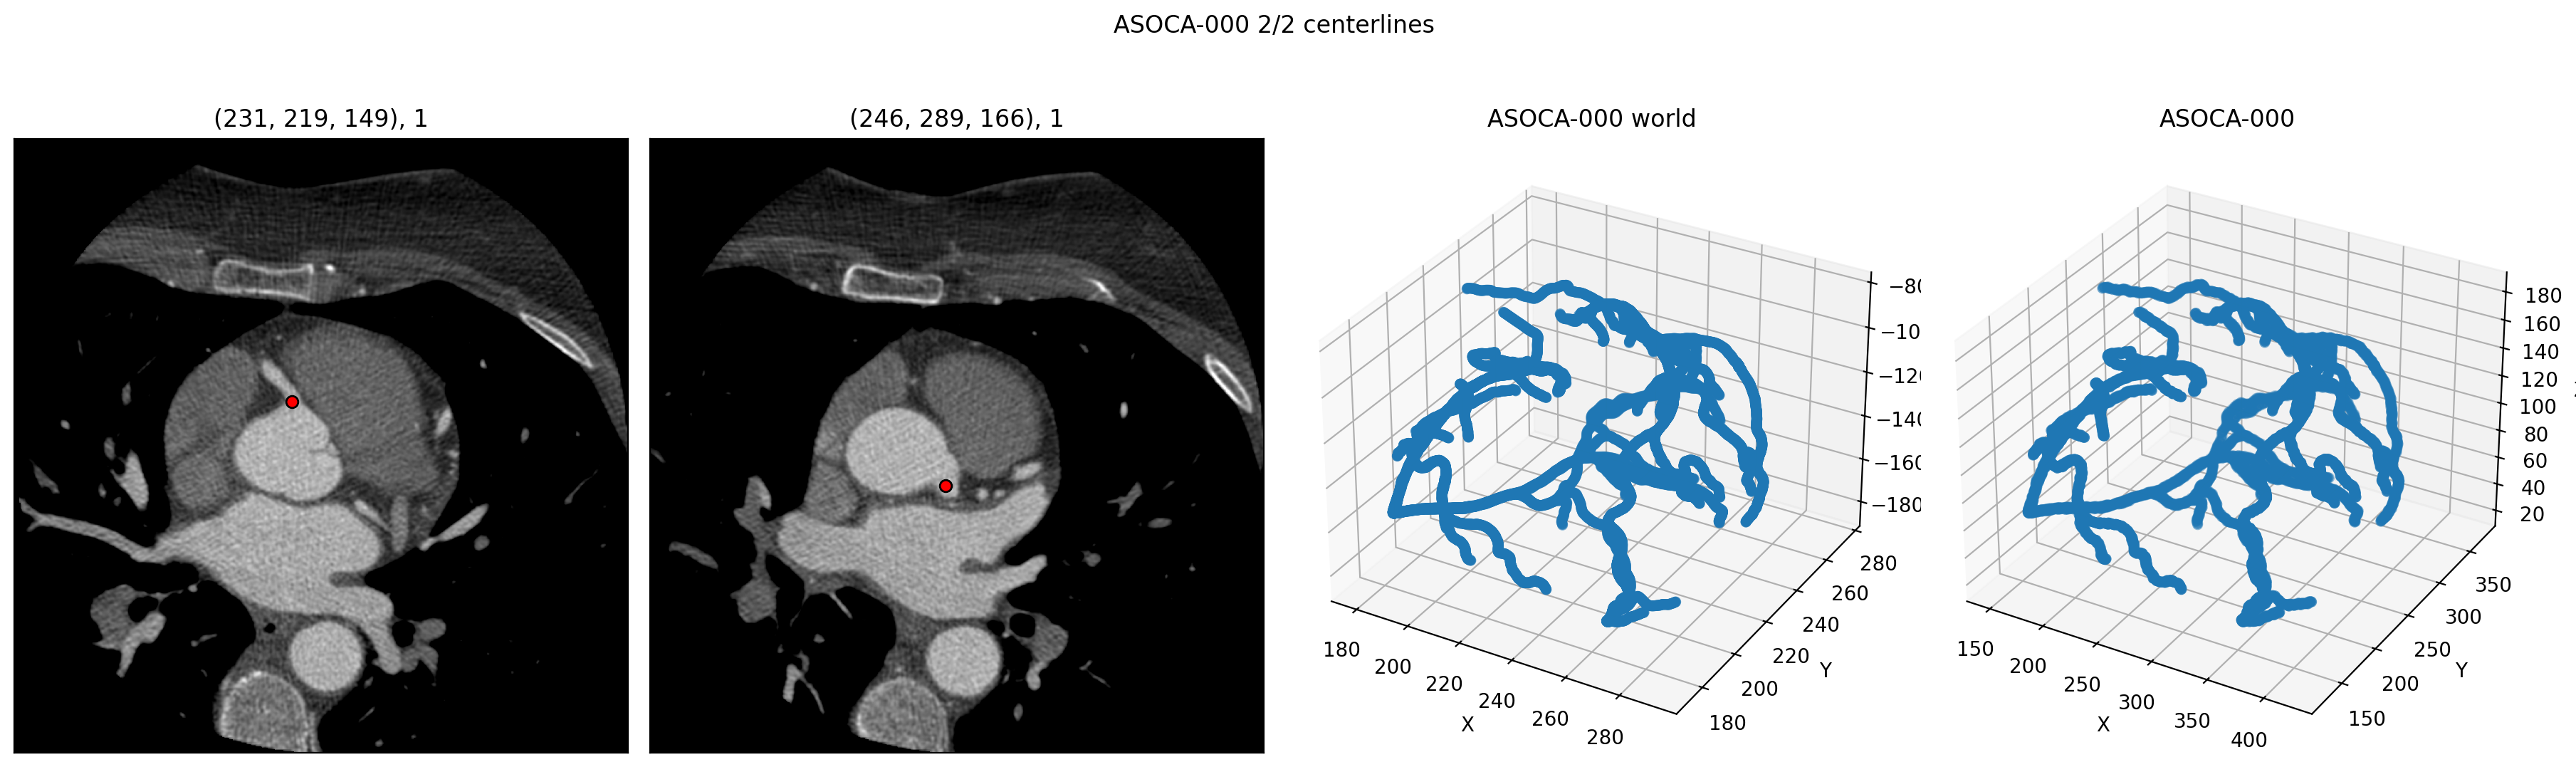

(6978, 3)
(3564, 3)


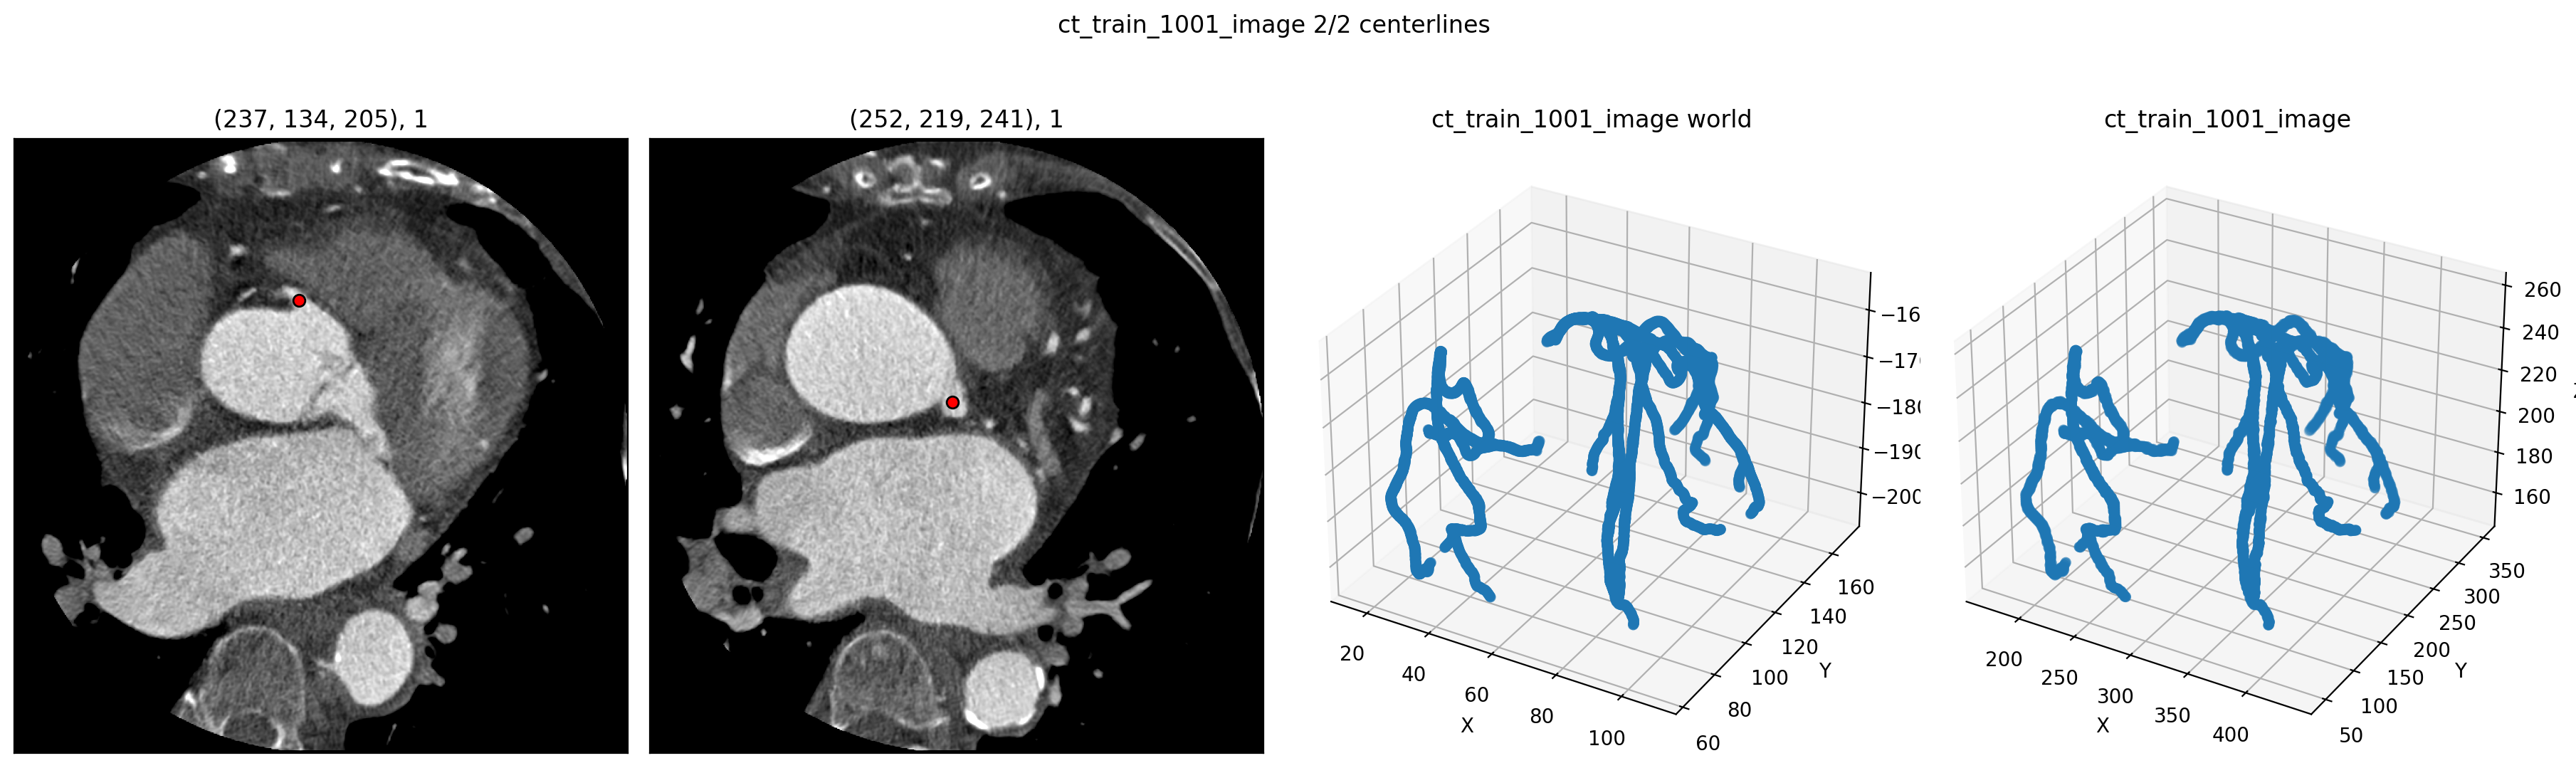

In [3]:
p_asoca = Path("/home/marco/data/ASOCA_Philips/images/ASOCA-000.h5")
p_mmwhs = Path("/home/marco/data/MMWHS/ct_train/ct_train_1001_image.h5")

im_asoca, meta_asoca, f_asoca = io_utils.load_h5_image(p_asoca)
im_mmwhs, meta_mmwhs, f_mmwhs = io_utils.load_h5_image(p_mmwhs)

ostia_asoca_img, ostia_mmwhs_img = [
    geom.world_to_image_coords(meta["ostia"], meta["offset"], meta["spacing"])
    for meta in [meta_asoca, meta_mmwhs]
]
for p, im, ostia, meta in zip(
    [p_asoca, p_mmwhs],
    [im_asoca, im_mmwhs],
    [ostia_asoca_img, ostia_mmwhs_img],
    [meta_asoca, meta_mmwhs],
):
    fig = plt.figure(figsize=(18, 6))
    ax0 = fig.add_subplot(1, 4, 1)
    ax1 = fig.add_subplot(1, 4, 2)
    ax2 = fig.add_subplot(1, 4, 3, projection="3d")
    ax3 = fig.add_subplot(1, 4, 4, projection="3d")
    viz.plot_axial_centerlines(
        im, ostia, title=io_utils.stem(p), vmin=VMIN, vmax=VMAX, axes=[ax0, ax1]
    )
    viz.plot_centerlines_3D(meta["centerlines"][..., :3], title=io_utils.stem(p) + " world", ax=ax2)
    ctls_img_coords = geom.world_to_image_coords(meta["centerlines"][..., :3], meta["offset"], meta["spacing"])
    print(ctls_img_coords.shape)
    ctls_img_coords = np.unique(ctls_img_coords, axis=0)
    print(ctls_img_coords.shape)
    viz.plot_centerlines_3D(ctls_img_coords, title=io_utils.stem(p), ax=ax3)
    plt.show()
    plt.close(fig)

In [4]:
ostia_im_coords = ostia_asoca_img
im_meta = meta_asoca
im = im_asoca

print(ostia_im_coords)
ostia_labelmap = torch.zeros(im.shape, dtype=torch.int8)
print(ostia_labelmap.shape)
ostia_labelmap[ostia_im_coords[:, 0], ostia_im_coords[:, 1], ostia_im_coords[:, 2]] = 1
print(ostia_labelmap.sum().item(), ostia_labelmap.dtype)
print(
    (array_u.grid_mask_to_cartesian_3D(ostia_labelmap) == torch.tensor(ostia_im_coords))
    .all()
    .item()
)

ctls_img_coords = geom.world_to_image_coords(
    torch.tensor(im_meta["centerlines"][..., :3]), im_meta["offset"], im_meta["spacing"]
).unique(dim=0)
print(ctls_img_coords.shape)
print(ctls_img_coords[:10])
labelmap = torch.zeros(im.shape, dtype=torch.int8)
print(labelmap.shape)
labelmap[ctls_img_coords[:, 0], ctls_img_coords[:, 1], ctls_img_coords[:, 2]] = 1
print(labelmap.sum().item(), labelmap.dtype)
(array_u.grid_mask_to_cartesian_3D(labelmap) == ctls_img_coords).all().item()

[[231 219 149]
 [246 289 166]]
torch.Size([512, 512, 204])
2 torch.int8


True
torch.Size([5564, 3])
tensor([[148, 270, 170],
        [149, 270, 171],
        [150, 270, 171],
        [151, 162,  54],
        [151, 163,  54],
        [151, 164,  53],
        [151, 165,  53],
        [151, 166,  52],
        [151, 166,  53],
        [151, 167,  52]])
torch.Size([512, 512, 204])
5564 torch.int8


True

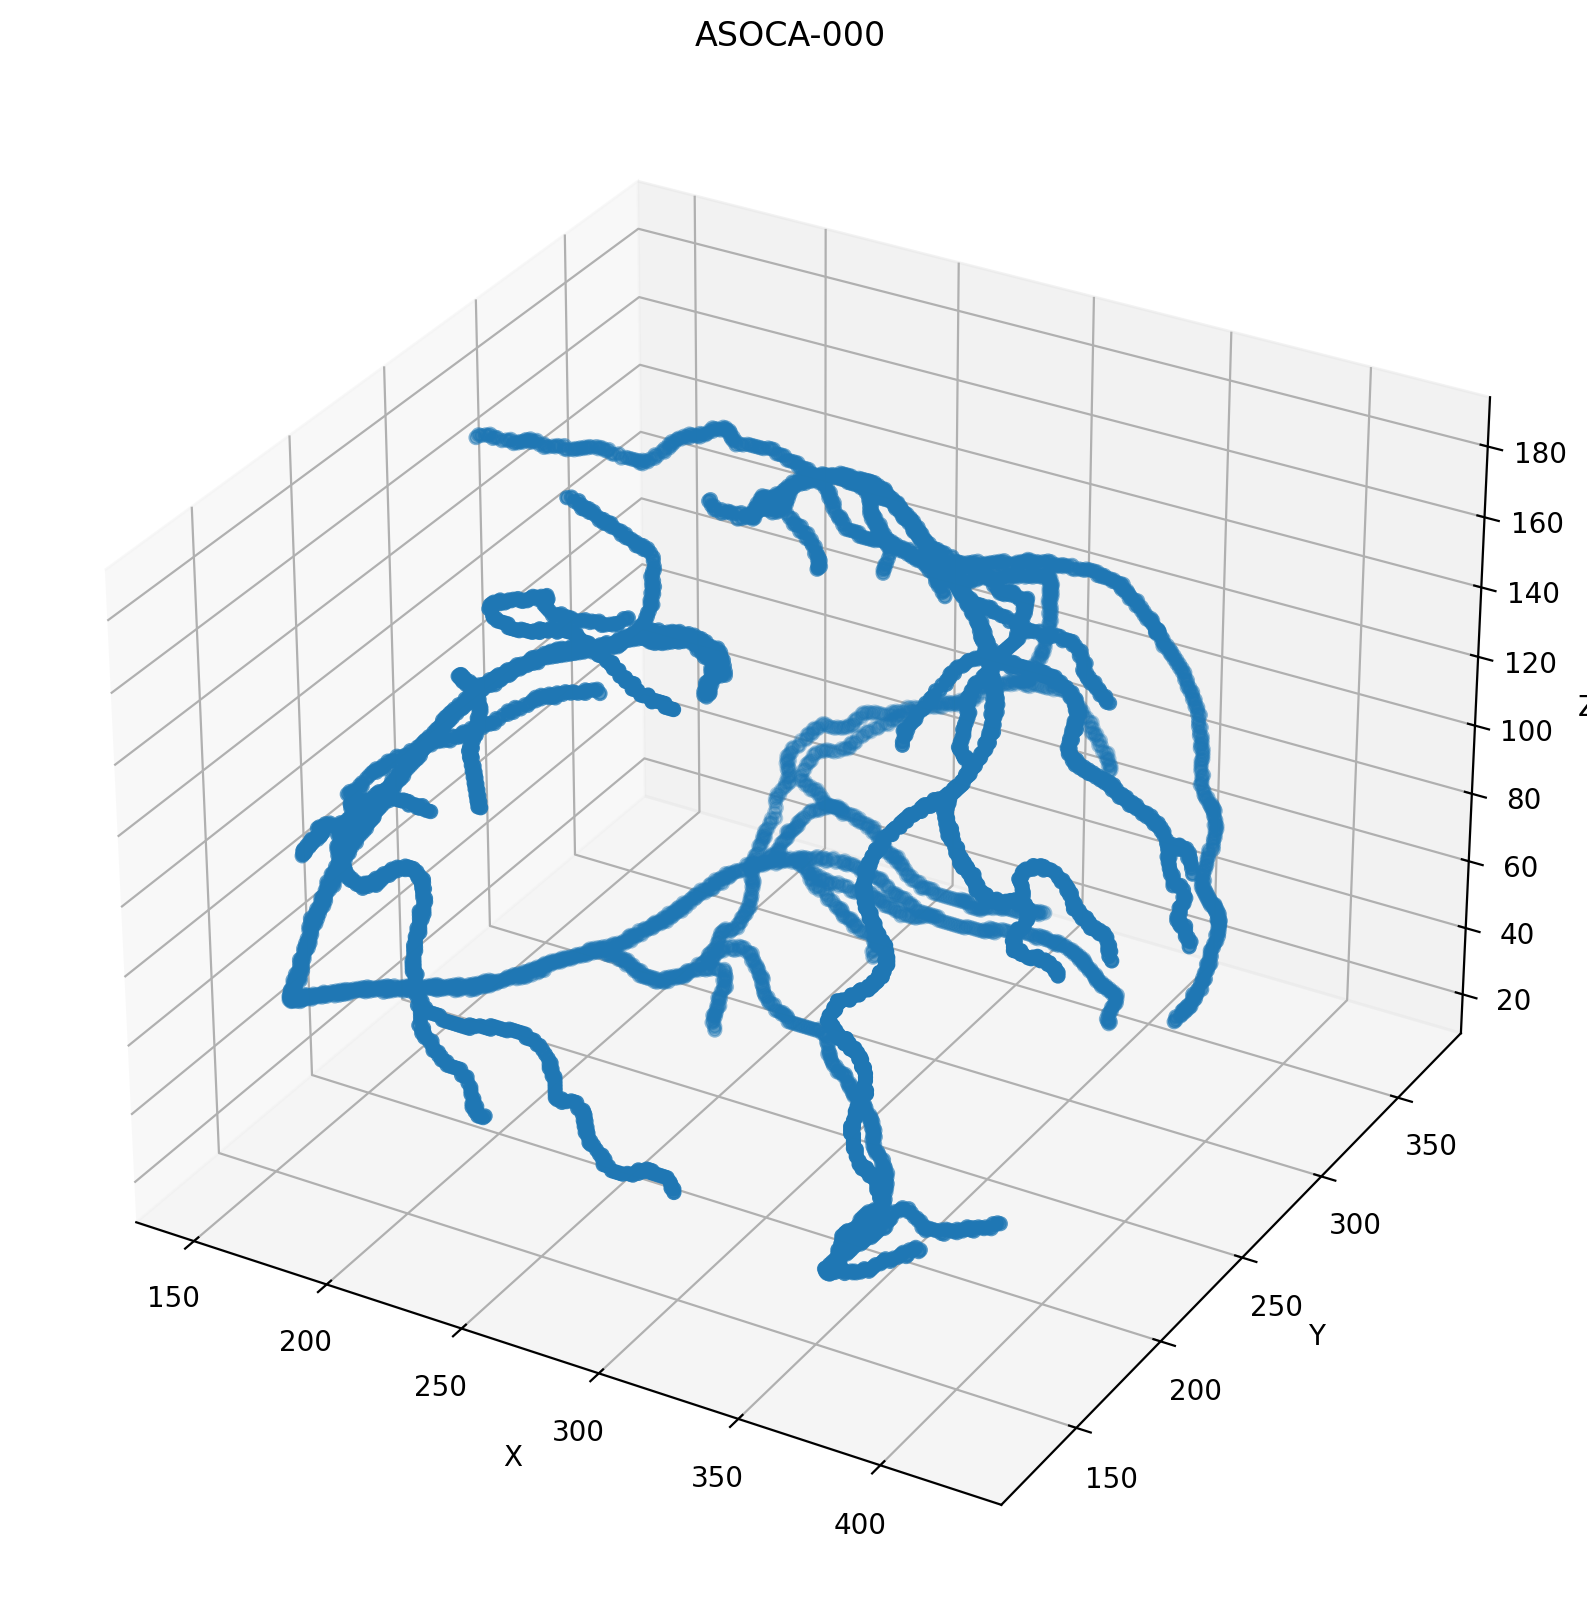

In [5]:
ax = viz.plot_centerlines_3D(
    array_u.grid_mask_to_cartesian_3D(labelmap), title=io_utils.stem(p_asoca)
)
plt.show()
plt.close(ax.get_figure())

In [6]:
# from monai.data import Dataset
# from monai.transforms import RandSpatialCropSamplesD
#
# centerlines_sampler_transform = RandCropByPosNegLabelD(
#     keys=["img", "centerlines"],
#     label_key="centerlines",
#     image_key="img",
#     spatial_size=(512, 512, 130),
#     pos=1,
#     neg=1,
#     num_samples=4,
# )
#
# dataset = Dataset(
#     [{"img": im_asoca[::][None, ...], "centerlines": labelmap[None, ...]}],
#     transform=centerlines_sampler_transform,
# )
#
# for p_dict in dataset[0]:
#     ctls = np.dstack(np.where(p_dict["centerlines"]))
#     ax = viz.plot_centerlines_3D(ctls[-1, :, :3])
#     plt.show()
#     plt.close(ax.get_figure())
#
#
# centerlines_sampler_transform = RandSpatialCropSamplesD(
#     keys=["img", "centerlines"],
#     roi_size=(-1, ) * 3,
#     random_size=False,
#     num_samples=1,
# )
#
# dataset = Dataset(
#     [{"img": im_asoca[::][None, ...], "centerlines": labelmap[None, ...]}],
#     transform=centerlines_sampler_transform,
# )
#
# for p_dict in dataset[0]:
#     ctls = torch.dstack(torch.where(p_dict["centerlines"]))
#     ax = viz.plot_centerlines_3D(ctls[-1, :, :3])
#     plt.show()
#     plt.close(ax.get_figure())

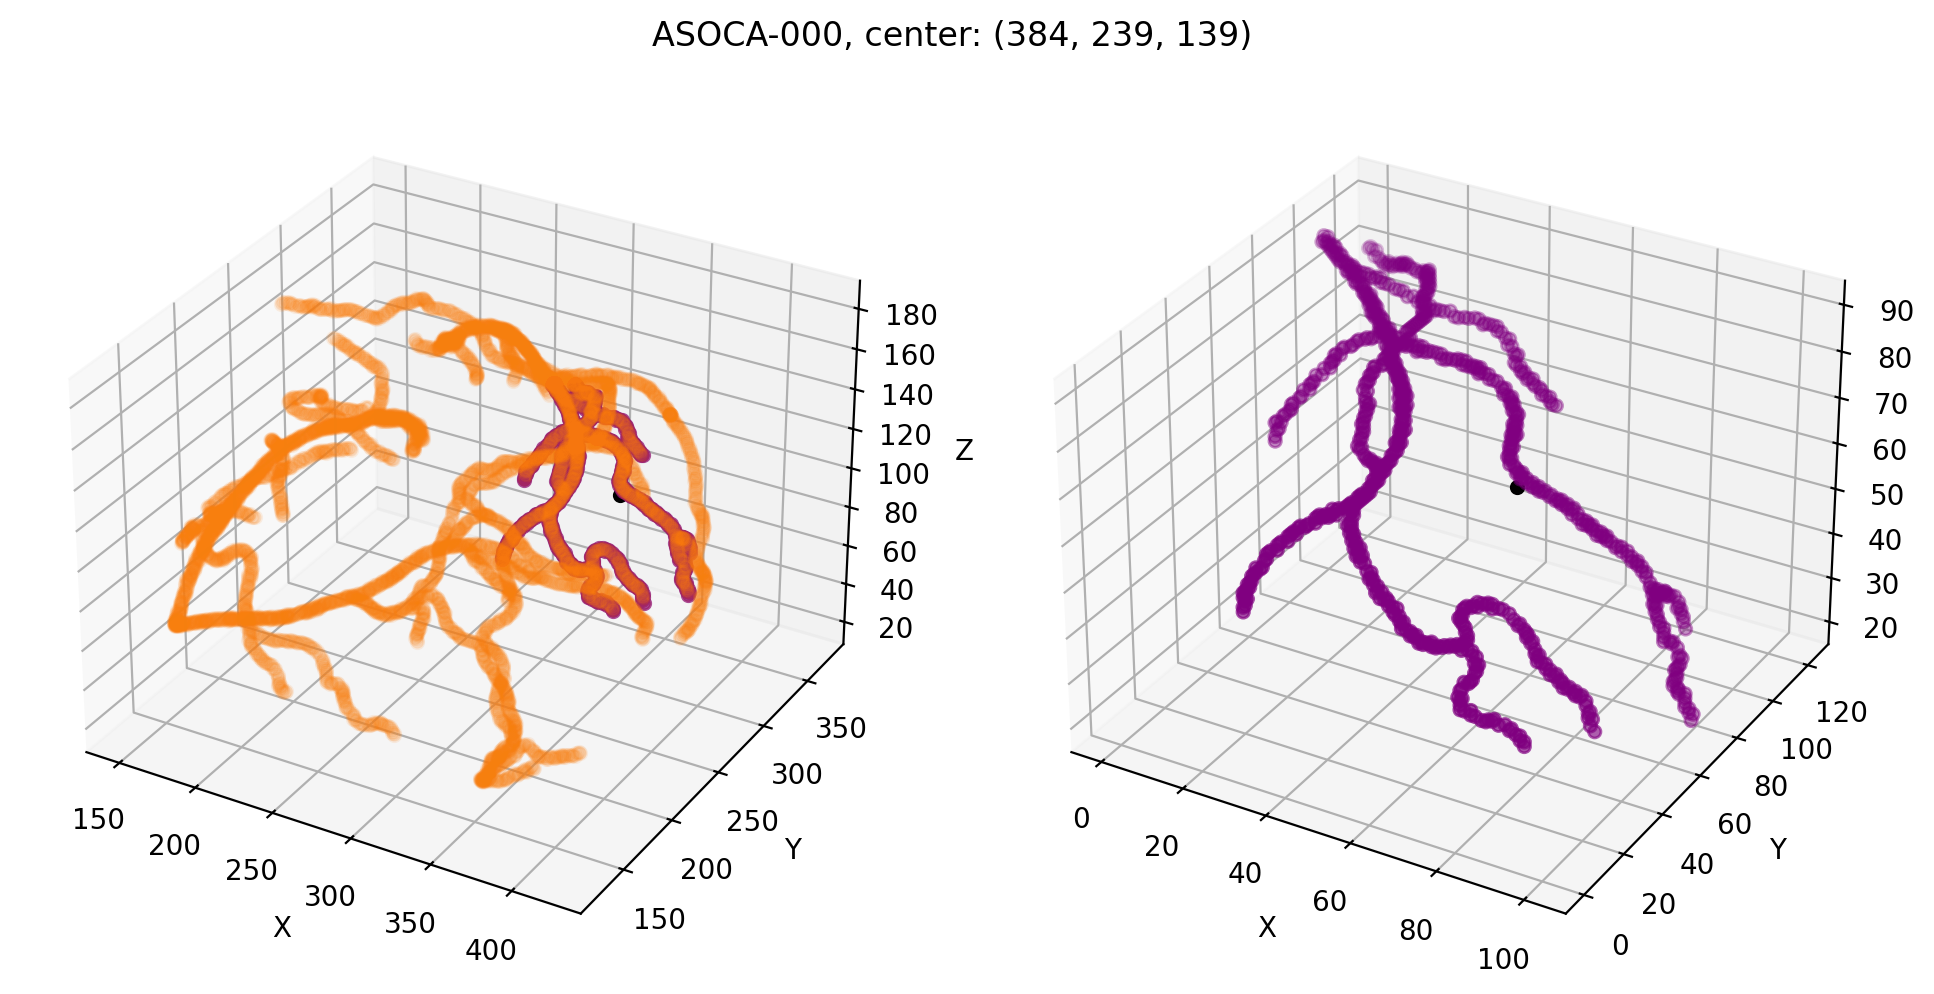

In [7]:
# %matplotlib widget

shape = (128,) * 3
*_, coords = geom.extract_random_3D_patch(im_asoca, shape)
ctls, ctls_mask = geom.extract_3D_patch(labelmap, shape, coords)
axes = viz.plot_extracted_patch_3D(labelmap, ctls_mask, ctls, coords)
fig = axes[0, 0].get_figure()
fig.suptitle(io_utils.stem(p_asoca) + f", center: {tuple(coords)}")

plt.tight_layout()
plt.show()

In [8]:
plt.close(fig)

In [9]:
rng = np.random.default_rng()

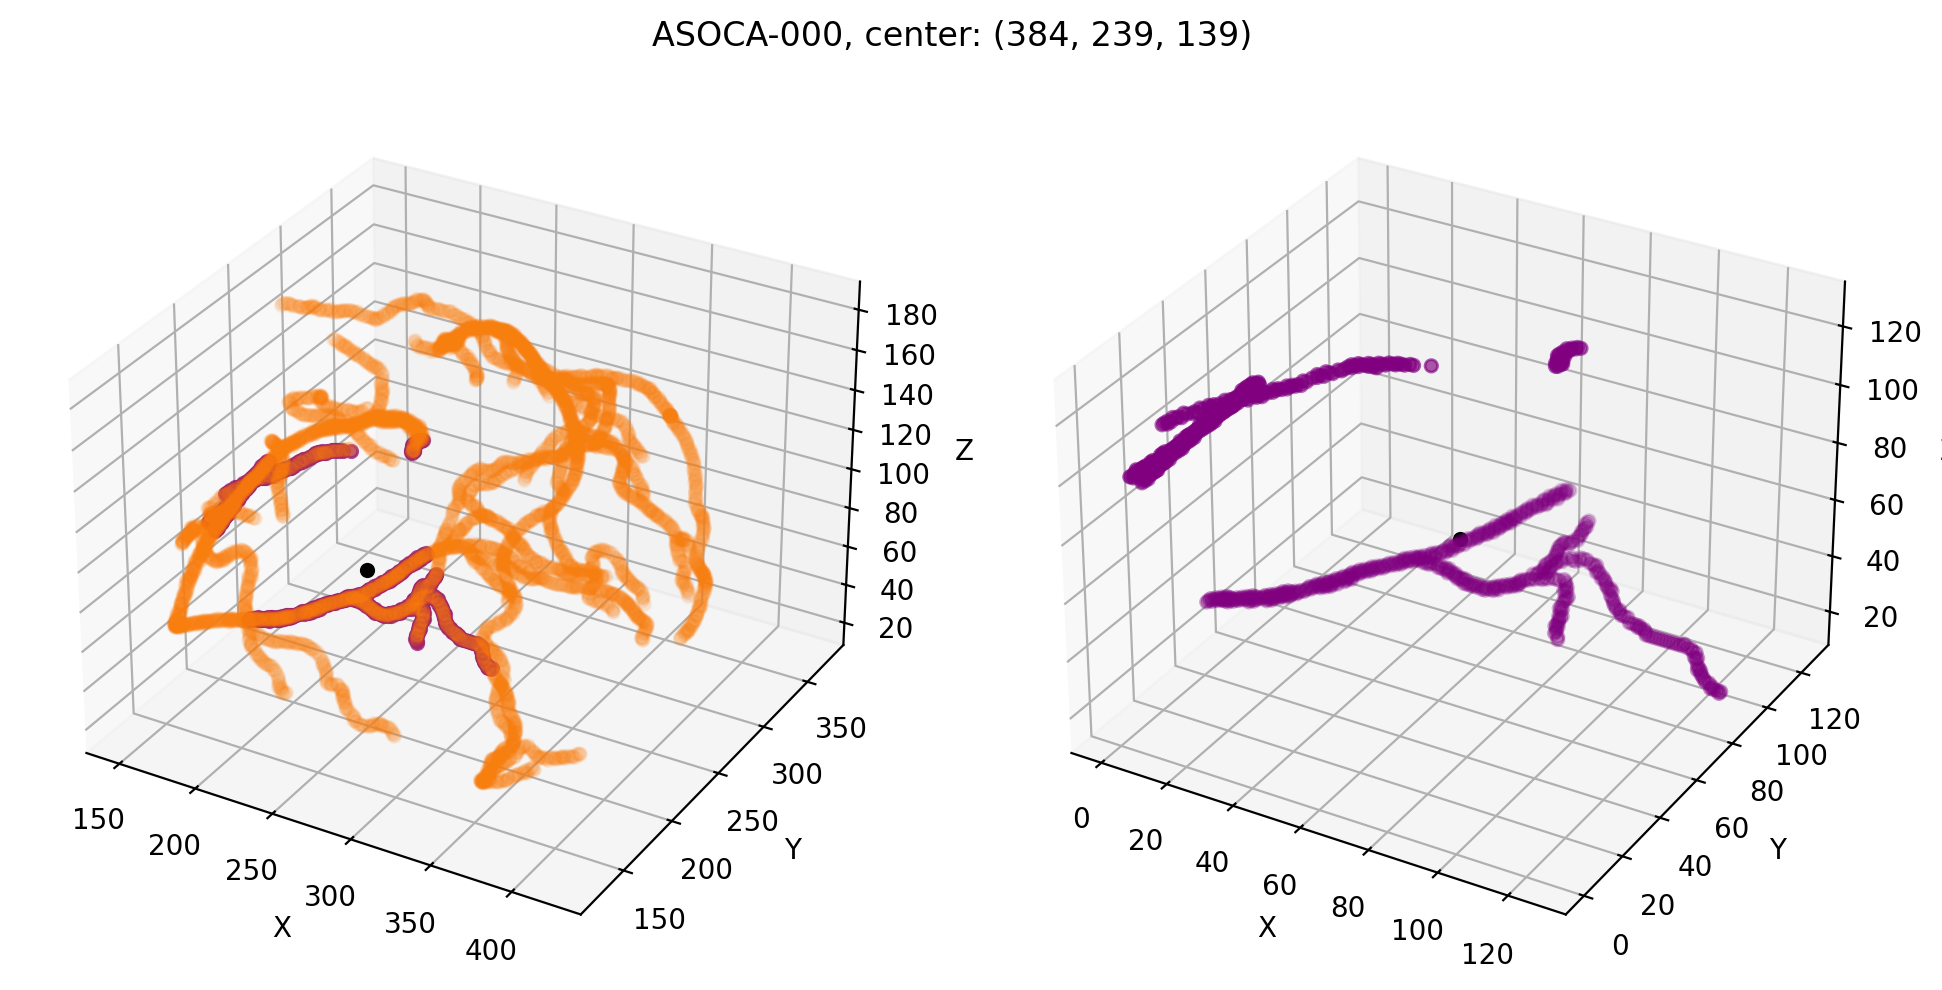

In [10]:
from contrast_gan_3D.dataset.HD5Dataset import HD5Dataset

with HD5Dataset(p_asoca, rng=rng) as data:
    origin, _, small_patch, big_patch  = data.sample_volume()

axes = viz.plot_extracted_patch_3D(data.labelmap, big_patch, small_patch, origin)
fig = axes[0, 0].get_figure()
fig.suptitle(io_utils.stem(p_asoca) + f", center: {tuple(coords)}")
plt.tight_layout()
plt.show()

In [12]:
plt.close(fig)

In [3]:
PREPROC_TRANSFORM = tio.Compose(
    [
        tio.ToCanonical(),
        tio.transforms.Lambda(
            lambda x: (x - 1024 if x.min() >= 0 else x).to(torch.int16)
        ),
        tio.Clamp(-260, 740),
    ]
)


# NOTE voxel spacing is different across datasets!
def load_subject(ccta_path: Path, centerlines_dir_path: Path) -> tio.Subject:
    image = sitk.ReadImage(ccta_path)
    subject_dict = {
        "ccta": tio.ScalarImage(ccta_path),
        "offset": torch.tensor(image.GetOrigin(), dtype=torch.float32),
        "centerlines": torch.from_numpy(
            io_utils.load_centerlines(centerlines_dir_path)
        ),
        "ostia": torch.from_numpy(
            io_utils.load_mevis_coords(centerlines_dir_path / "ostia.xml")[0]
        ),
        "path": ccta_path,
        "subset": "ASOCA" if "ASOCA" in str(ccta_path) else "MMWHS"
    }
    return tio.Subject(subject_dict)


def load_ccta_dataset(
    ccta_paths: List[Path],
    centerlines_dir_paths: List[Path],
    transform: Optional[tio.Transform] = None,
) -> tio.SubjectsDataset:
    subjects = [
        load_subject(ccta, centerline_dir)
        for ccta, centerline_dir in zip(ccta_paths, centerlines_dir_paths)
    ]
    if transform is None:
        transform = PREPROC_TRANSFORM
    return tio.SubjectsDataset(subjects=subjects, transform=transform)

('L', 'A', 'S')


('R', 'A', 'S')


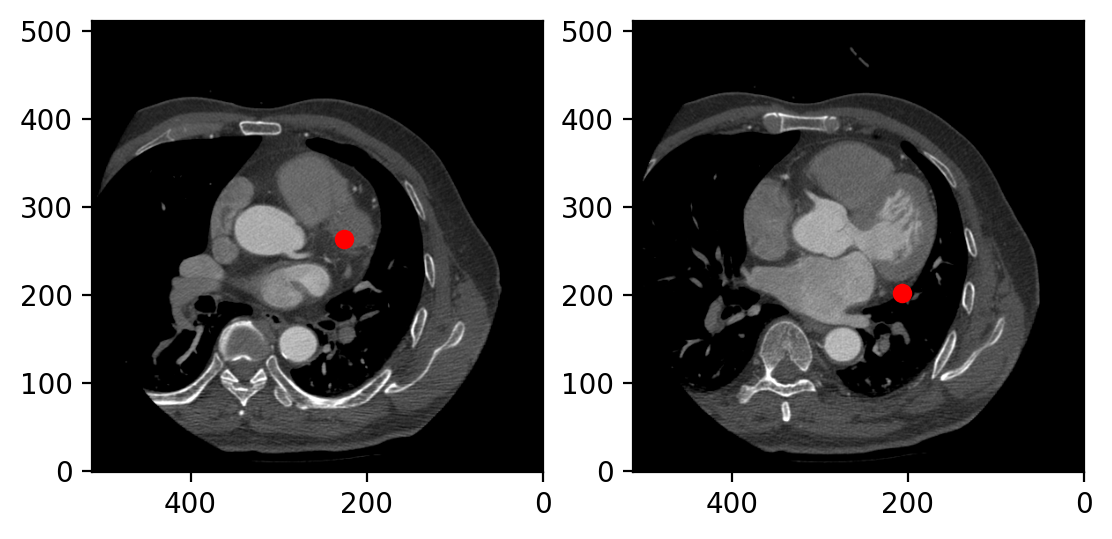

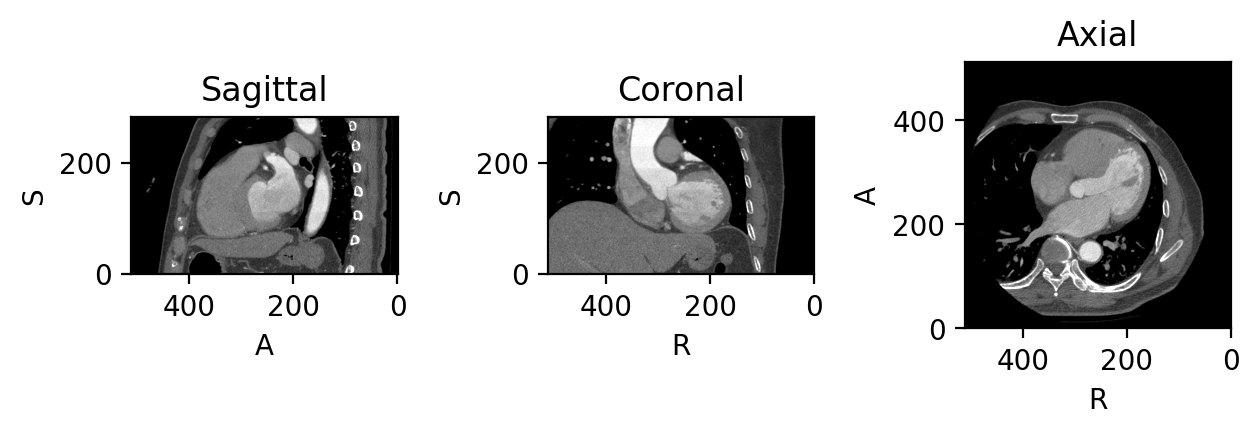

In [355]:
# p = Path("/home/marco/data/MMWHS/ct_train/ct_train_1001_image.nii.gz")
# p = Path("/home/marco/data/ASOCA_Philips/images/ASOCA-002.mhd")
p = Path("/home/marco/data/MMWHS/ct_test/ct_test_2040_image.nii.gz")

# im, meta = io_utils.load_sitk_image(p)
# plt.imshow(im[..., im.shape[-1] // 2].T, vmin=VMIN, vmax=VMAX, cmap="gray")
# plt.show()
# plt.close()

_, meta, f = io_utils.load_h5_image(p.parent / f"{io_utils.stem(p)}.h5")
f.close()

ostia_im = geom.world_to_image_coords(meta["ostia"], meta["offset"], meta["spacing"])

im = tio.ScalarImage(p)
print(im.orientation)
im = PREPROC_TRANSFORM(im)
print(im.orientation)

data = tio.visualization.rotate(im.data[-1])

fig, axes = plt.subplots(1, 2)
for ax, ostia in zip(axes, ostia_im):
    ax.imshow(
        data[..., ostia[-1]],
        vmin=VMIN,
        vmax=VMAX,
        cmap="gray",
        origin="lower",
        aspect=im.spacing[1] / im.spacing[0],
    )
    ax.scatter(ostia[0], ostia[1], color="red")
    ax.invert_xaxis()
plt.show()
plt.close(fig)

im.plot()

In [4]:
DATASET_DIRS = [
    Path("/home/marco/data") / p
    for p in ["ASOCA_Philips/images", "MMWHS/ct_train", "MMWHS/ct_test"]
]

CCTA_PATHS = [
    p
    for data_dir in DATASET_DIRS
    for p in sorted(list(data_dir.glob("*.mhd")) + list(data_dir.glob("*image.nii.gz")))
]
CENTERLINES_DIR_PATHS = [
    p.parent
    / "auto_centerlines"
    / (io_utils.basename(p) if ".nii.gz" in str(p) else io_utils.stem(p))
    for p in CCTA_PATHS
]

In [5]:
dataset = load_ccta_dataset(CCTA_PATHS, CENTERLINES_DIR_PATHS)
len(dataset)

120

/home/marco/data/ASOCA_Philips/images/ASOCA-000.mhd


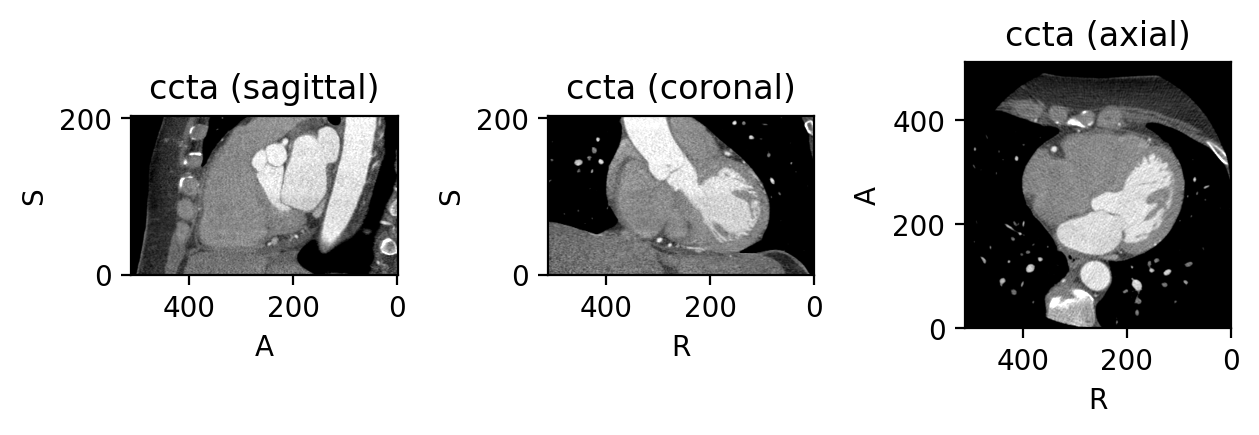

In [6]:
print(dataset[0].path)
dataset[0].plot()
plt.close()

In [286]:
rng = np.random.default_rng()
rng


Generator(PCG64) at 0x7FE92FAC6260

In [295]:
idx = rng.choice(len(dataset))
idx

80

/home/marco/data/MMWHS/ct_test/ct_test_2001_image.nii.gz
(1, 512, 512, 224)


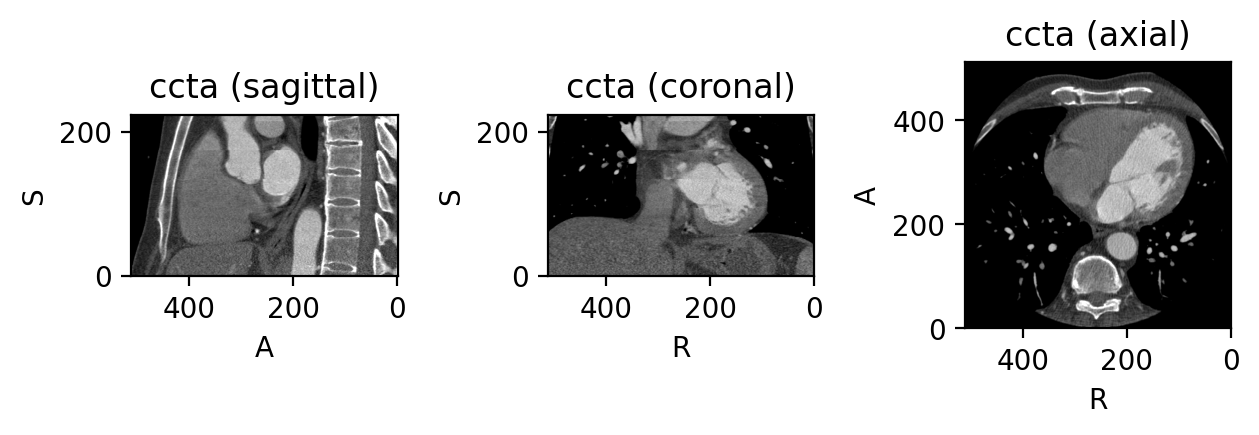

In [296]:
print(dataset[idx].path)
print(dataset[idx].shape)
dataset[idx].plot()
plt.close()

/home/marco/data/MMWHS/ct_test/ct_test_2001_image.nii.gz
tensor([[247, 180, 152],
        [276, 231, 179]])


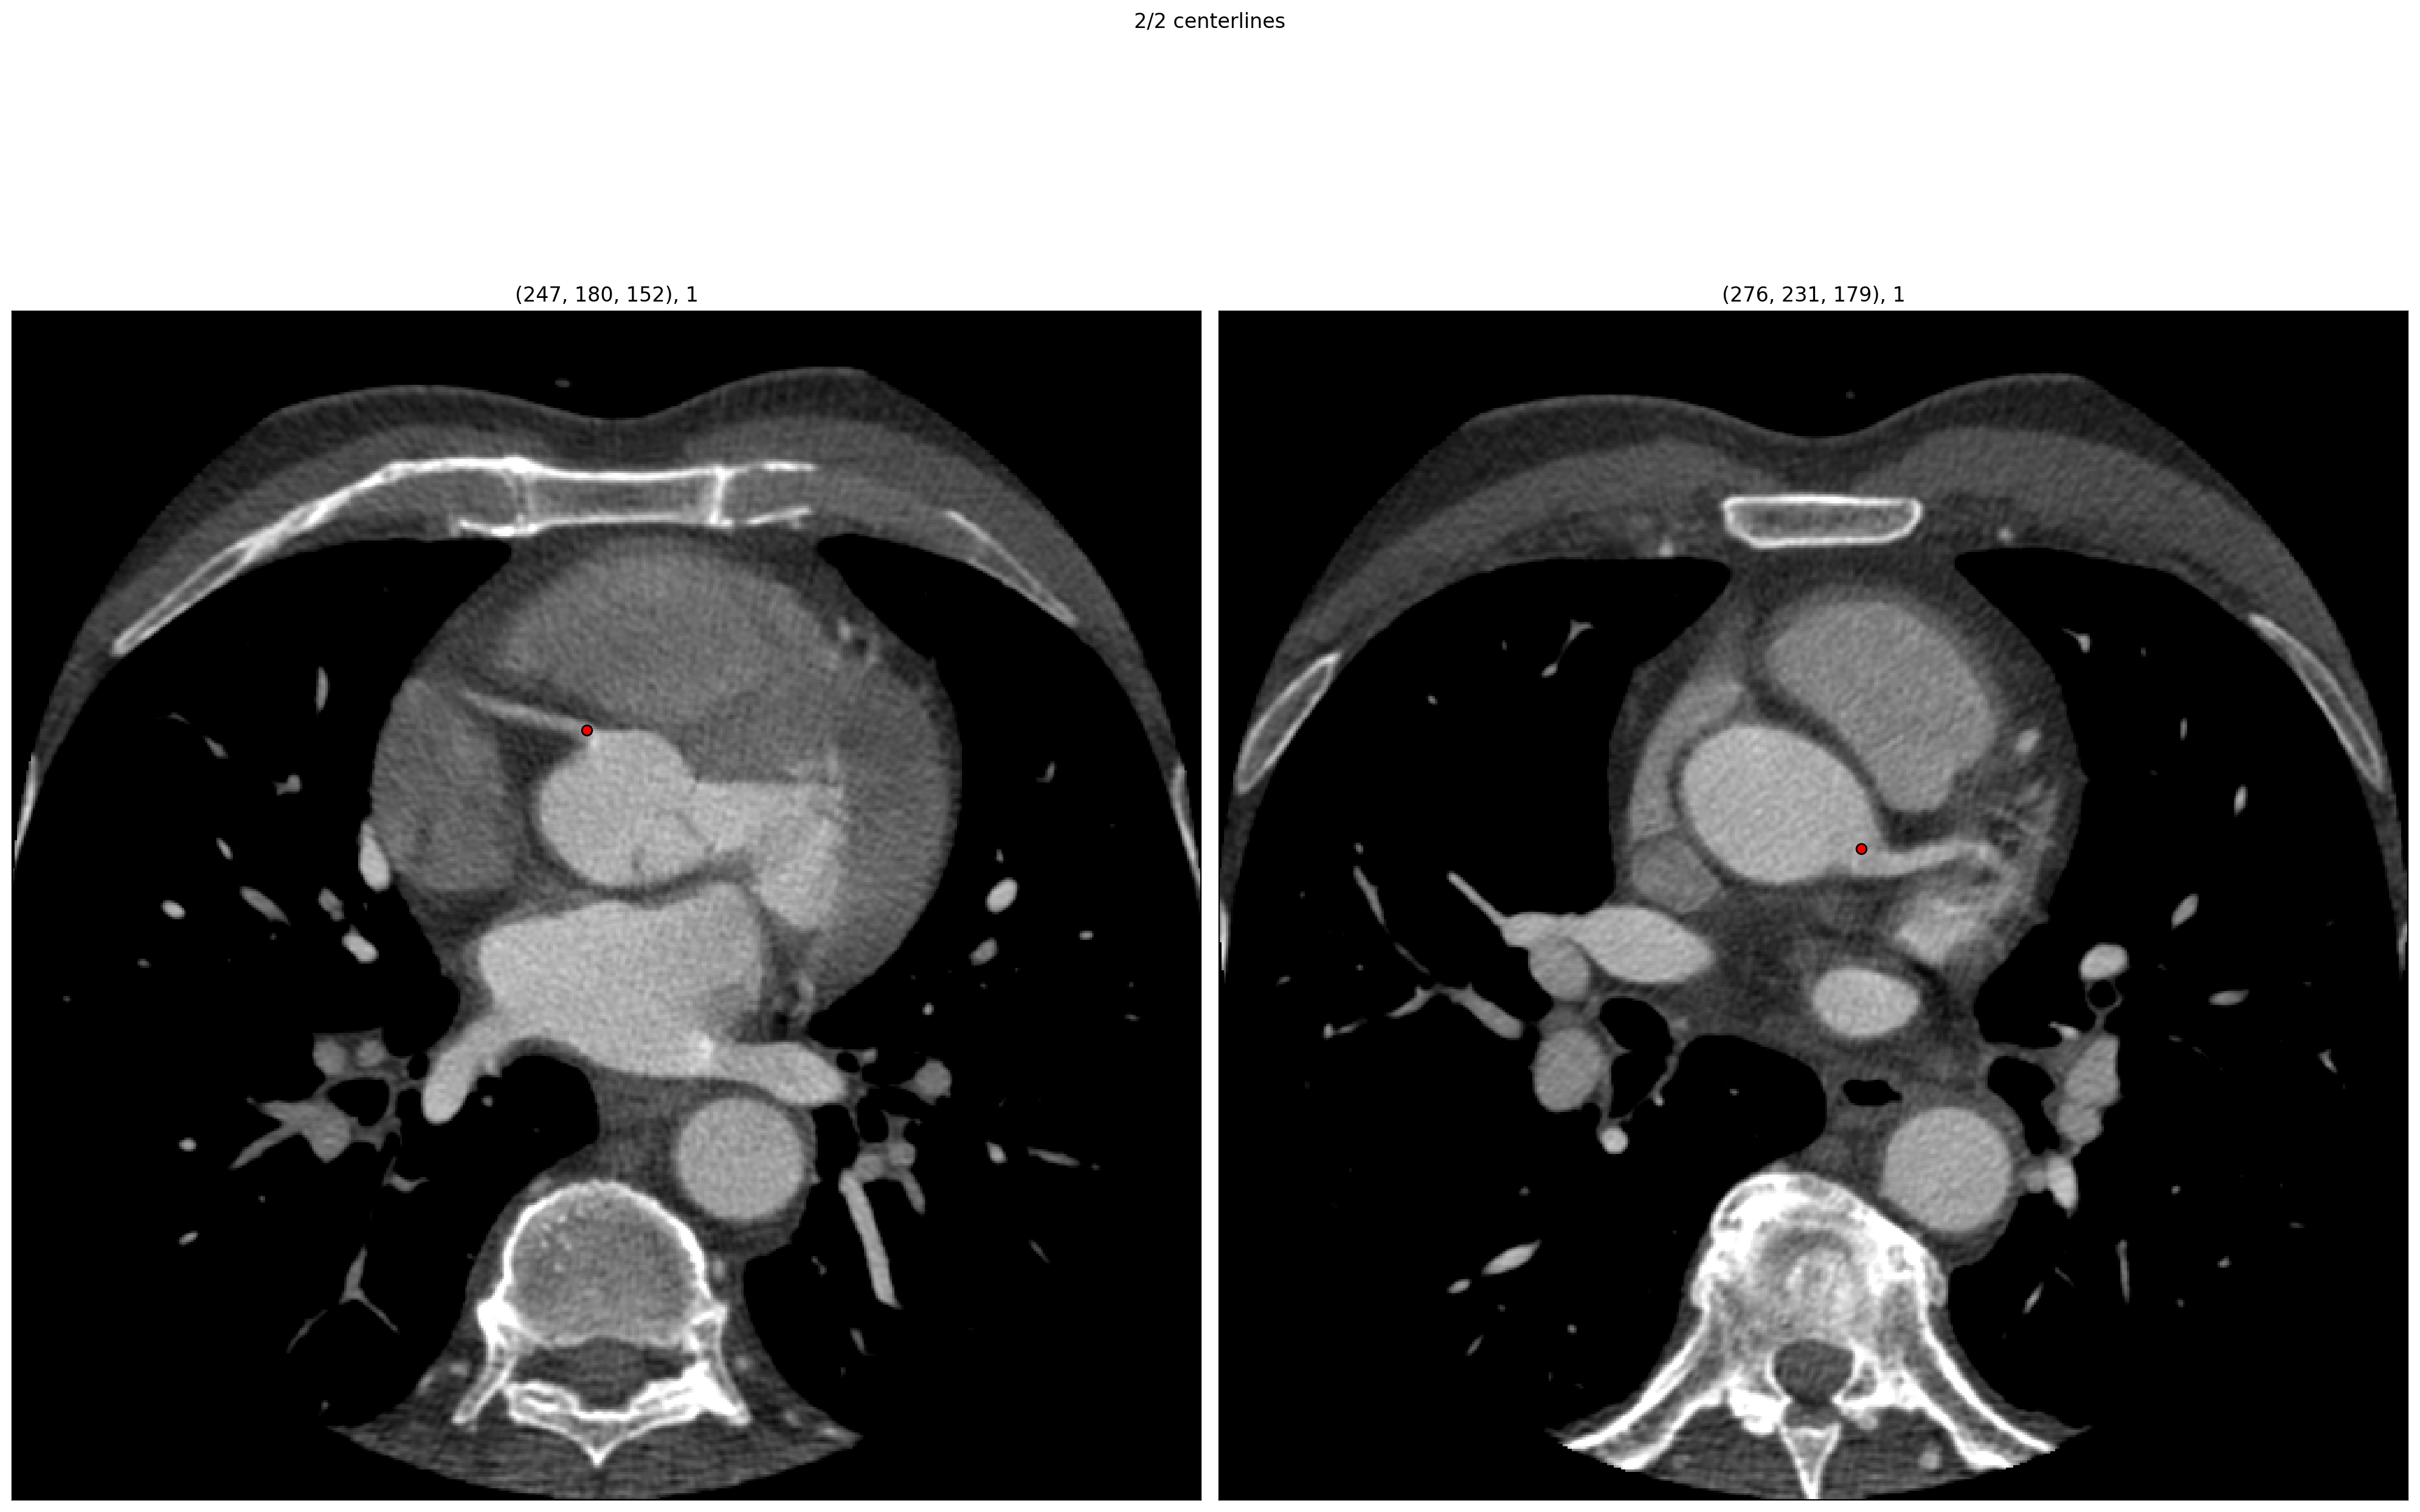

[[247 180 152]
 [276 231 179]]


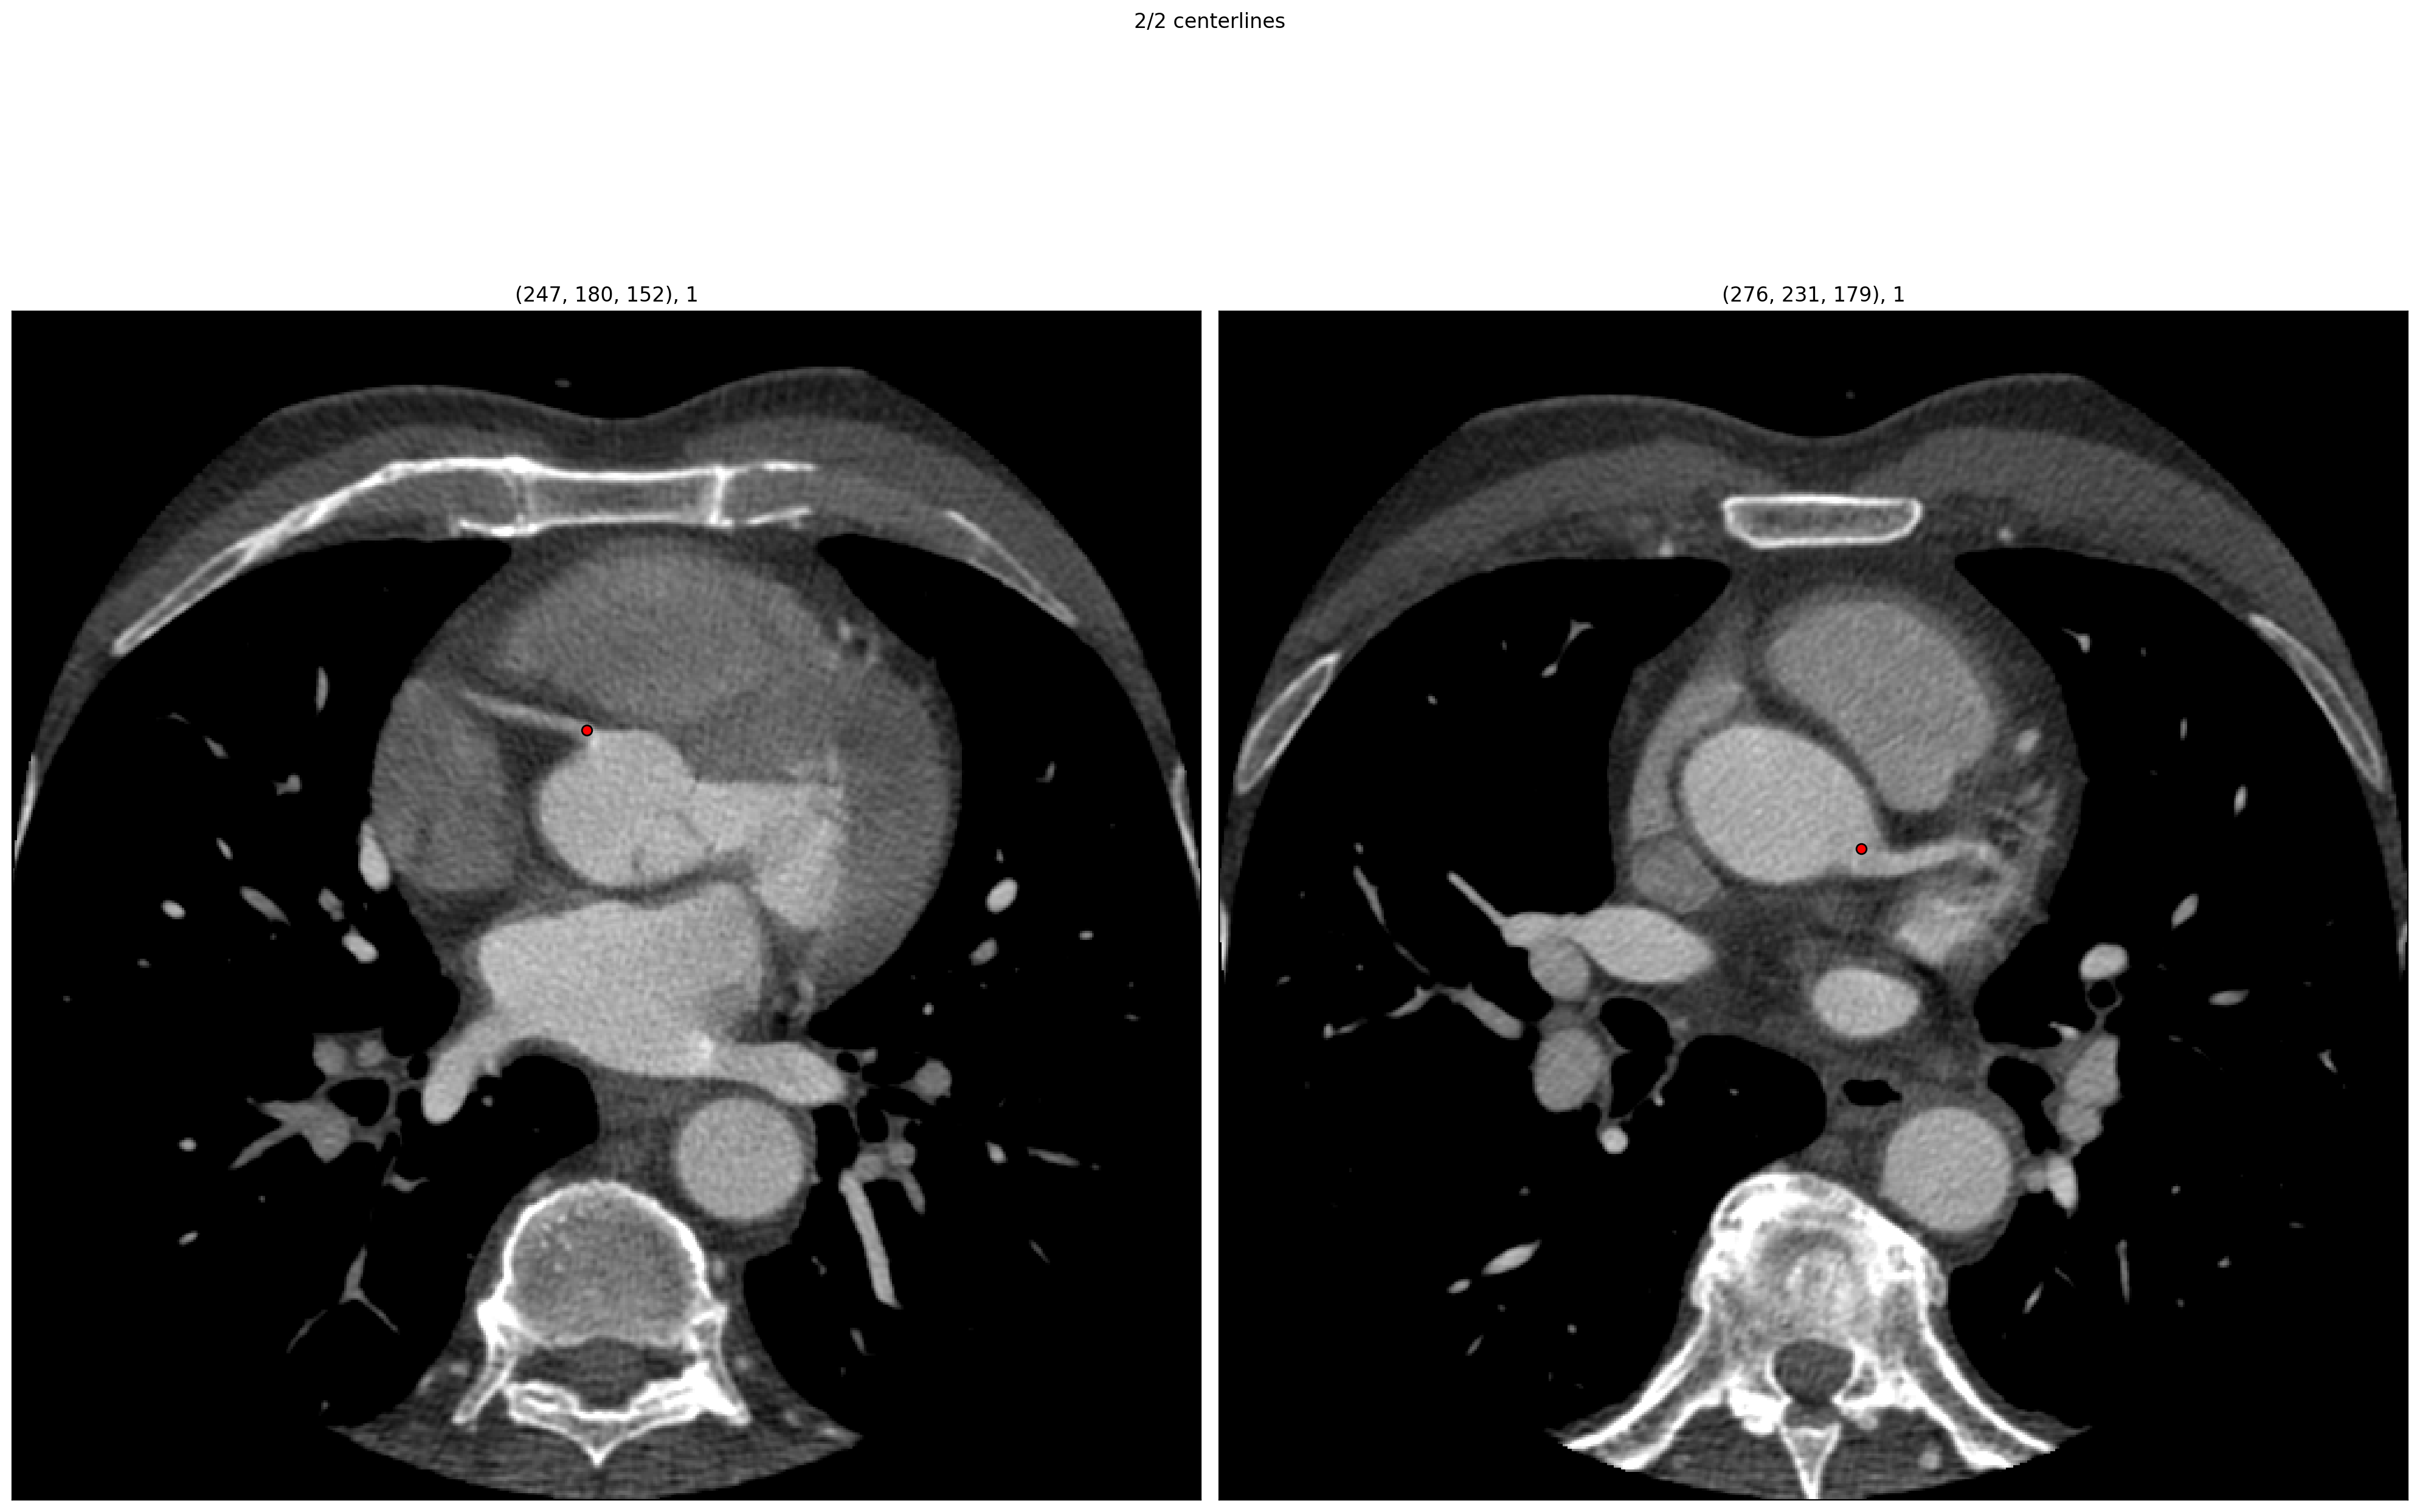

In [297]:
subject = dataset[idx]
print(subject.path)
im_coords = geom.world_to_image_coords(subject.ostia, subject.offset, subject.spacing)
print(im_coords)

# NOTE the flipping of image and ostia coordinates for the tio.ScalarImage dataset
plottable = np.flipud(np.fliplr(subject.ccta.data.cpu().numpy().squeeze()))
axes = viz.plot_axial_centerlines(plottable, np.flipud(im_coords))
plt.show()
plt.close(axes[0, 0].get_figure())

img, meta, f = io_utils.load_h5_image(
    subject.path.parent / f"{io_utils.stem(subject.path)}.h5"
)
im_coords = geom.world_to_image_coords(meta["ostia"], meta["offset"], meta["spacing"])
print(im_coords)
axes = viz.plot_axial_centerlines(img, im_coords, vmin=VMIN, vmax=VMAX)
plt.show()
plt.close(axes[0, 0].get_figure())
f.close()

In [298]:
# ctls_img_coords = geom.world_to_image_coords(
#     subject.centerlines[..., :3], subject.offset, subject.spacing
# ).unique(dim=0)
# print(ctls_img_coords.size(0))
# labelmap = torch.zeros_like(subject.ccta.data, dtype=torch.int8)
# print(labelmap.shape)
# labelmap[0, ctls_img_coords[:, 0], ctls_img_coords[:, 1], ctls_img_coords[:, 2]] = 1
# print(labelmap.sum().item(), labelmap.dtype)

In [299]:
print(subject.path)
ostia_im_coords = geom.world_to_image_coords(subject.ostia, subject.offset, subject.spacing)
print(ostia_im_coords)
# ostia_im_coords = torch.flipud(ostia_im_coords)
# print(ostia_im_coords)
labelmap = torch.zeros_like(subject.ccta.data, dtype=torch.int8)
print(labelmap.shape)
labelmap[0, ostia_im_coords[:, 0], ostia_im_coords[:, 1], ostia_im_coords[:, 2]] = 1
print(labelmap.sum().item(), labelmap.dtype)

/home/marco/data/MMWHS/ct_test/ct_test_2001_image.nii.gz
tensor([[247, 180, 152],
        [276, 231, 179]])
torch.Size([1, 512, 512, 224])
2 torch.int8


In [300]:
tio_labelmap = tio.LabelMap(tensor=labelmap, affine=subject.ccta.affine)
print(tio_labelmap)
# tio_labelmap.count_labels()

LabelMap(shape: (1, 512, 512, 224); spacing: (0.45, 0.45, 0.62); orientation: RAS+; dtype: torch.CharTensor; memory: 56.0 MiB)


In [301]:
PATCH_SIZE = np.array([128, 128, 10])
PATCH_SIZE

array([128, 128,  10])

/home/marco/data/MMWHS/ct_test/ct_test_2001_image.nii.gz
Subject(Keys: ('ccta', 'offset', 'centerlines', 'ostia', 'path', 'subset', 'centerlines_labelmap'); images: 2)


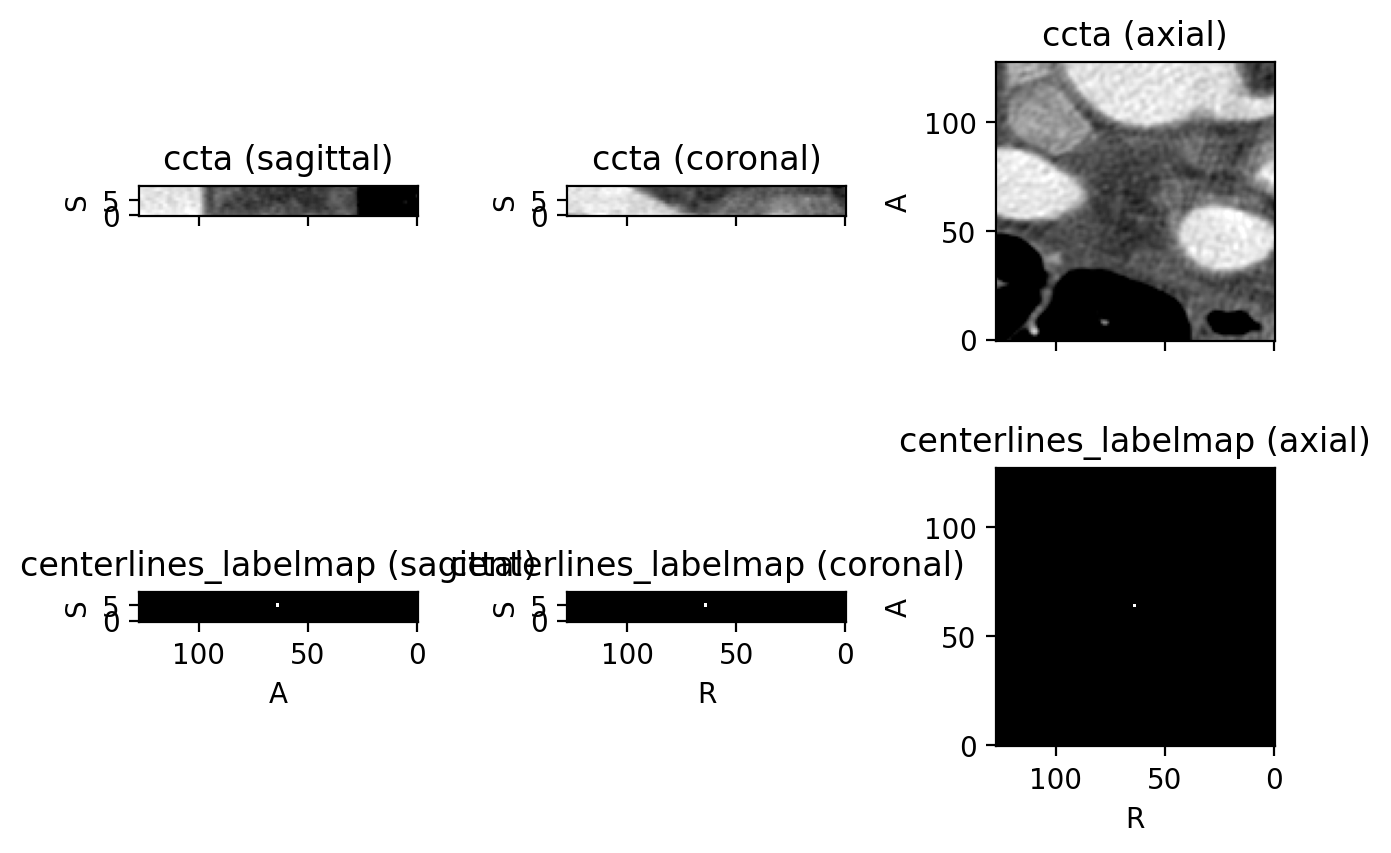

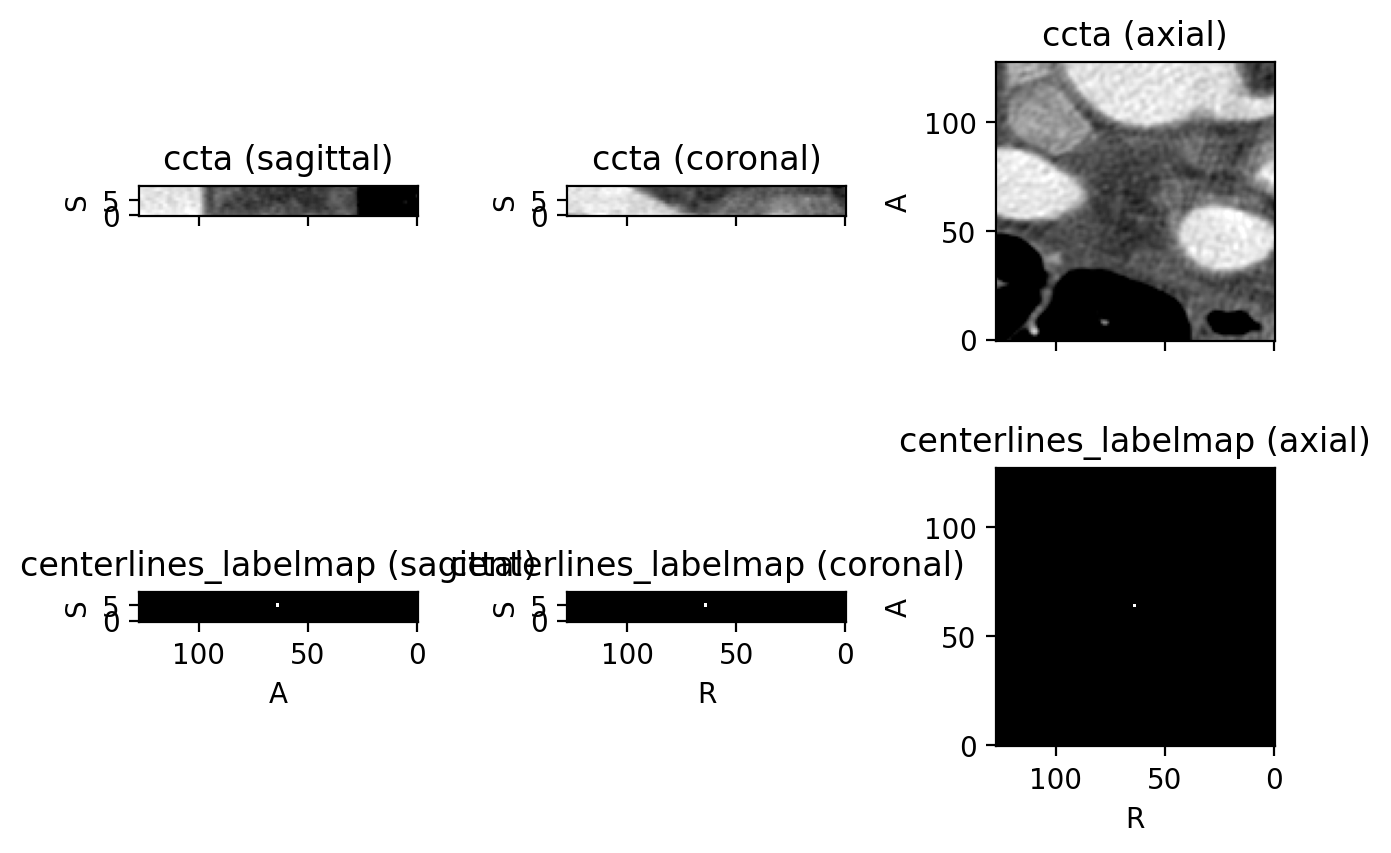

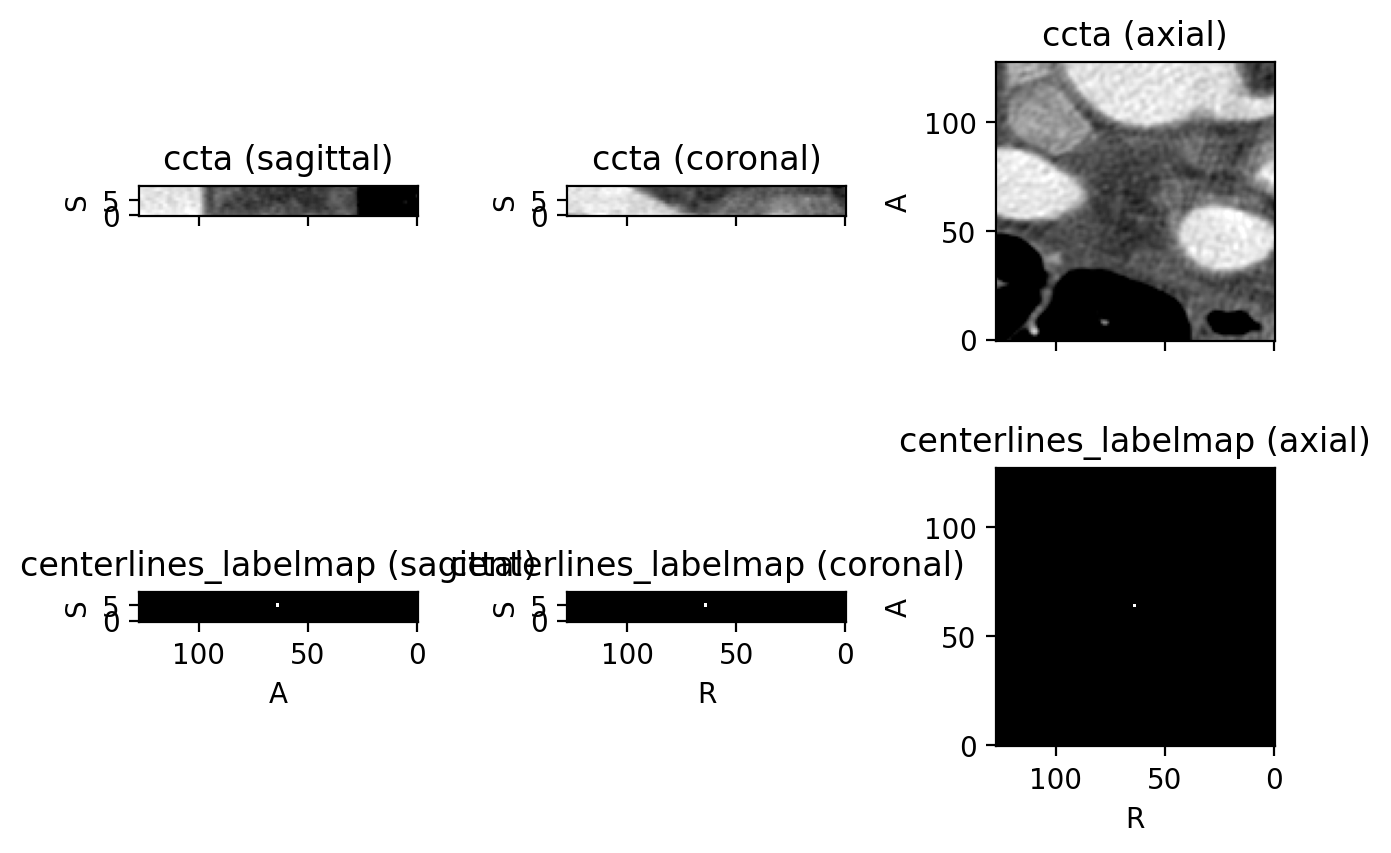

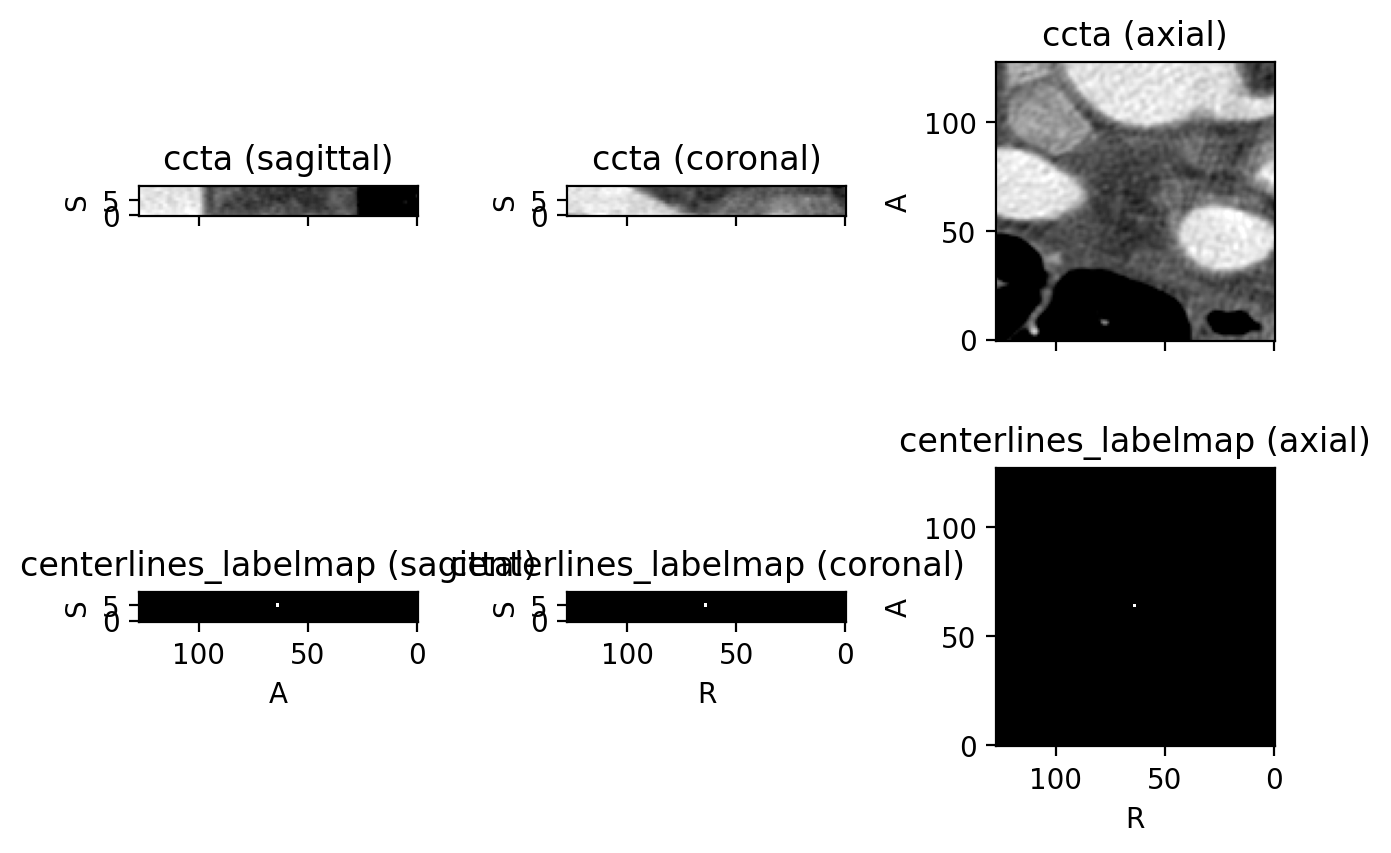

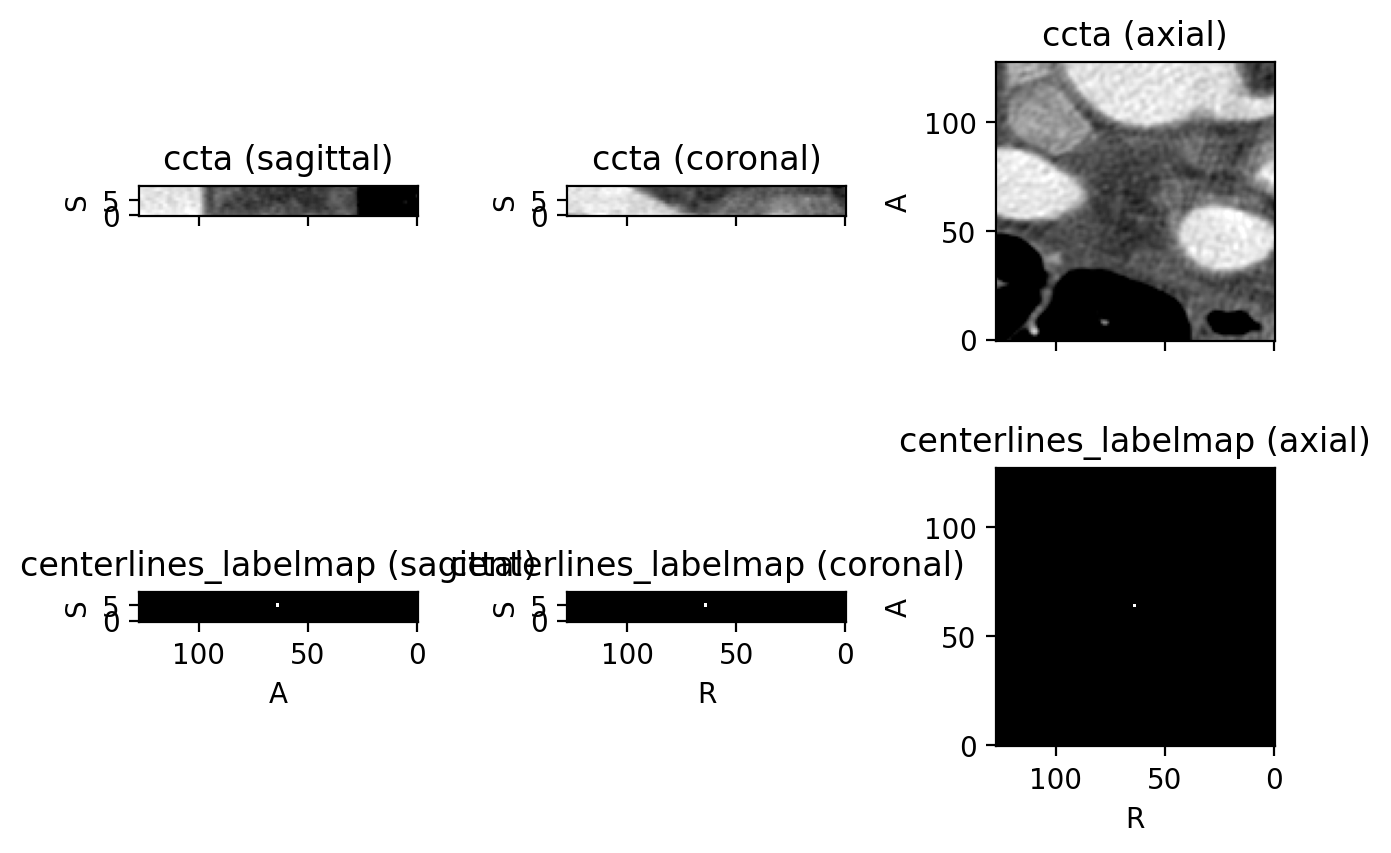

In [307]:
from copy import deepcopy

new_subj = deepcopy(subject)
print(new_subj.path)
new_subj["centerlines_labelmap"] = tio_labelmap
print(new_subj)

sampler = tio.LabelSampler(patch_size=PATCH_SIZE, label_name="centerlines_labelmap")
gen = sampler(new_subj, num_patches=5)
for patch in gen:
    # els = torch.where(patch.centerlines_labelmap.data[0] == 1)
    # x = np.dstack(els).squeeze()
    # print(x.min(), x.max())
    patch.plot()

In [18]:
sampler = tio.UniformSampler(PATCH_SIZE)
sampler.patch_size

array([128, 128,  30], dtype=uint16)

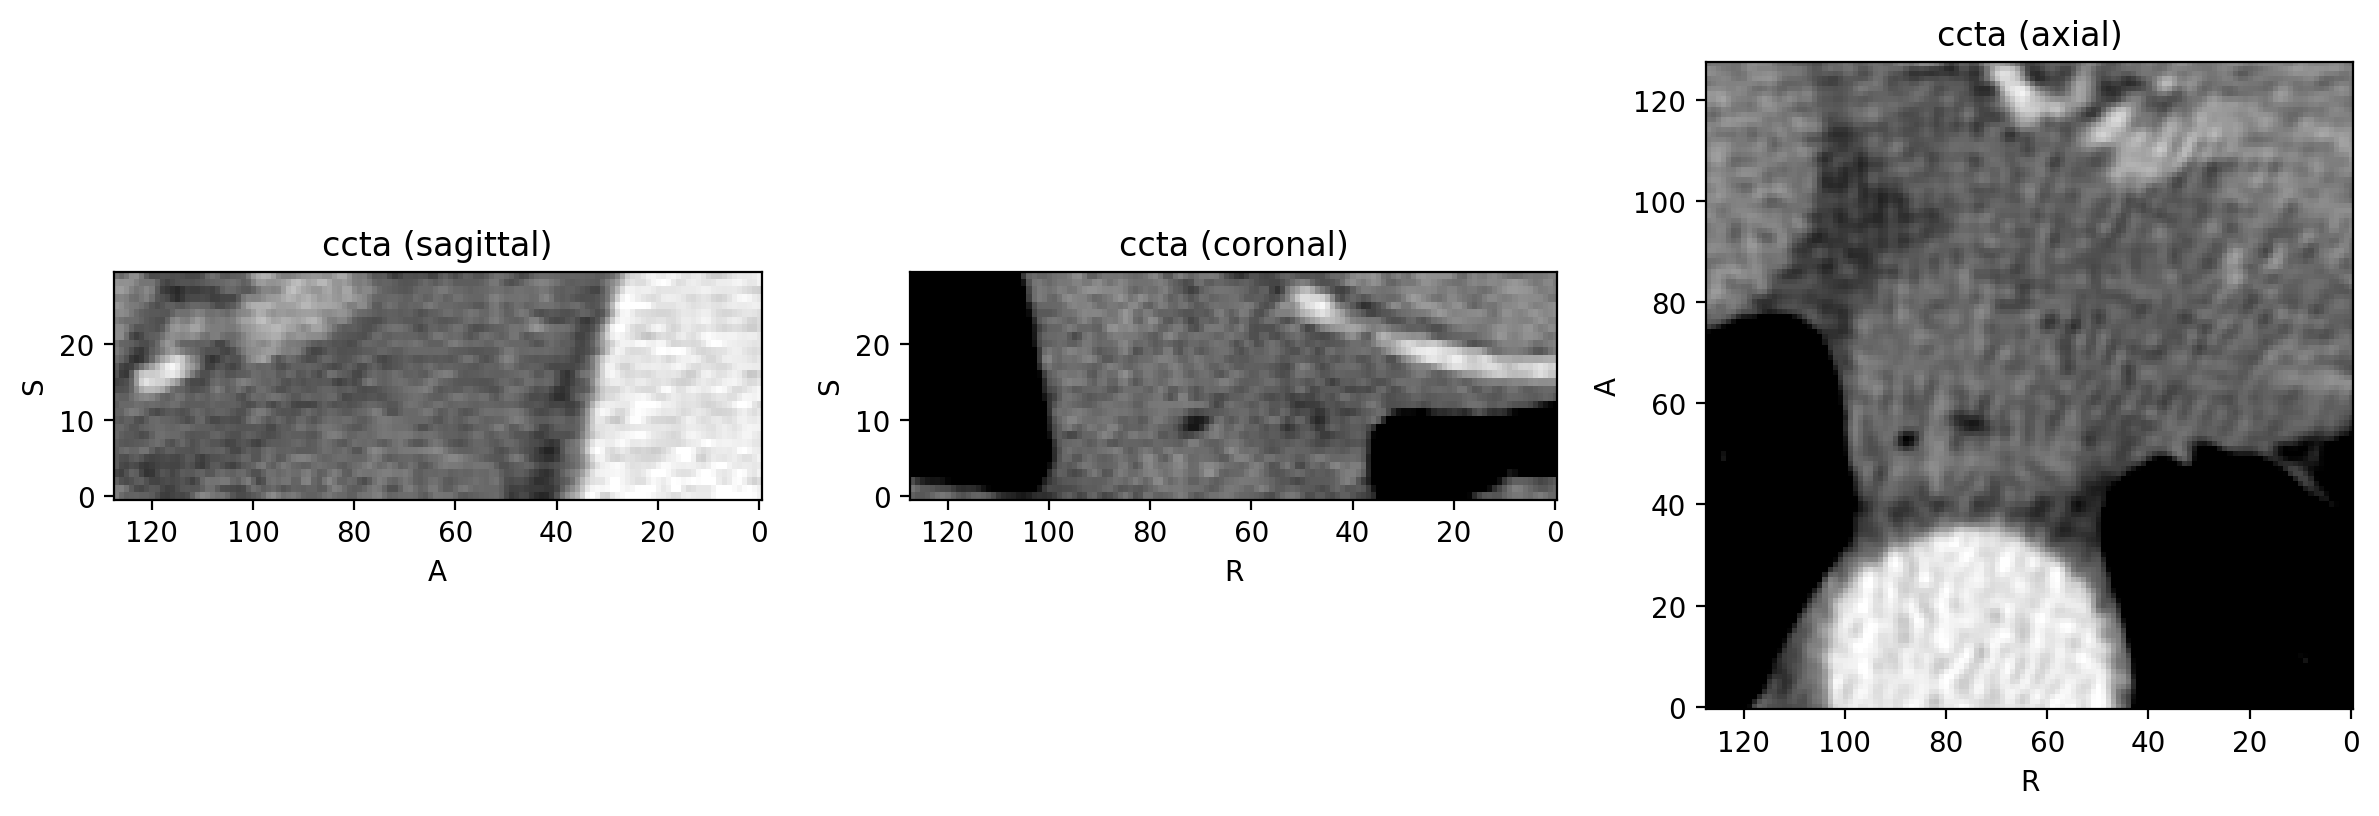

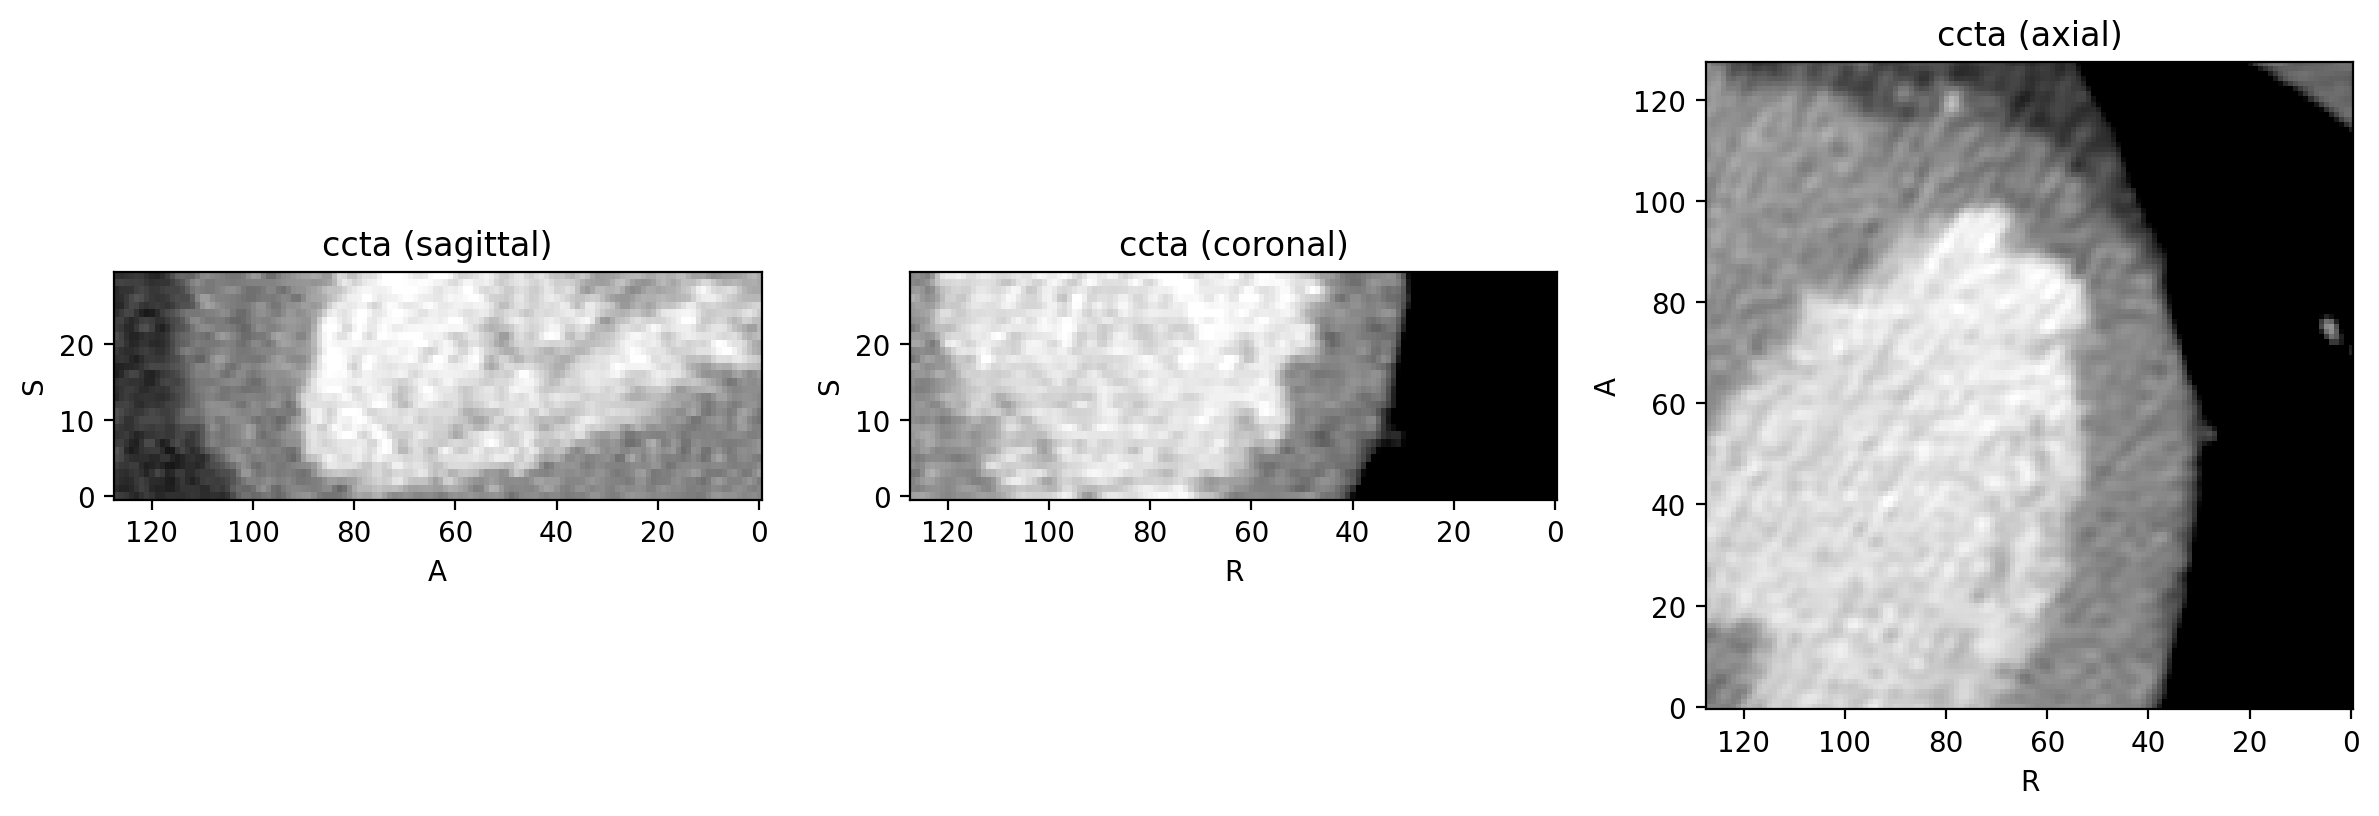

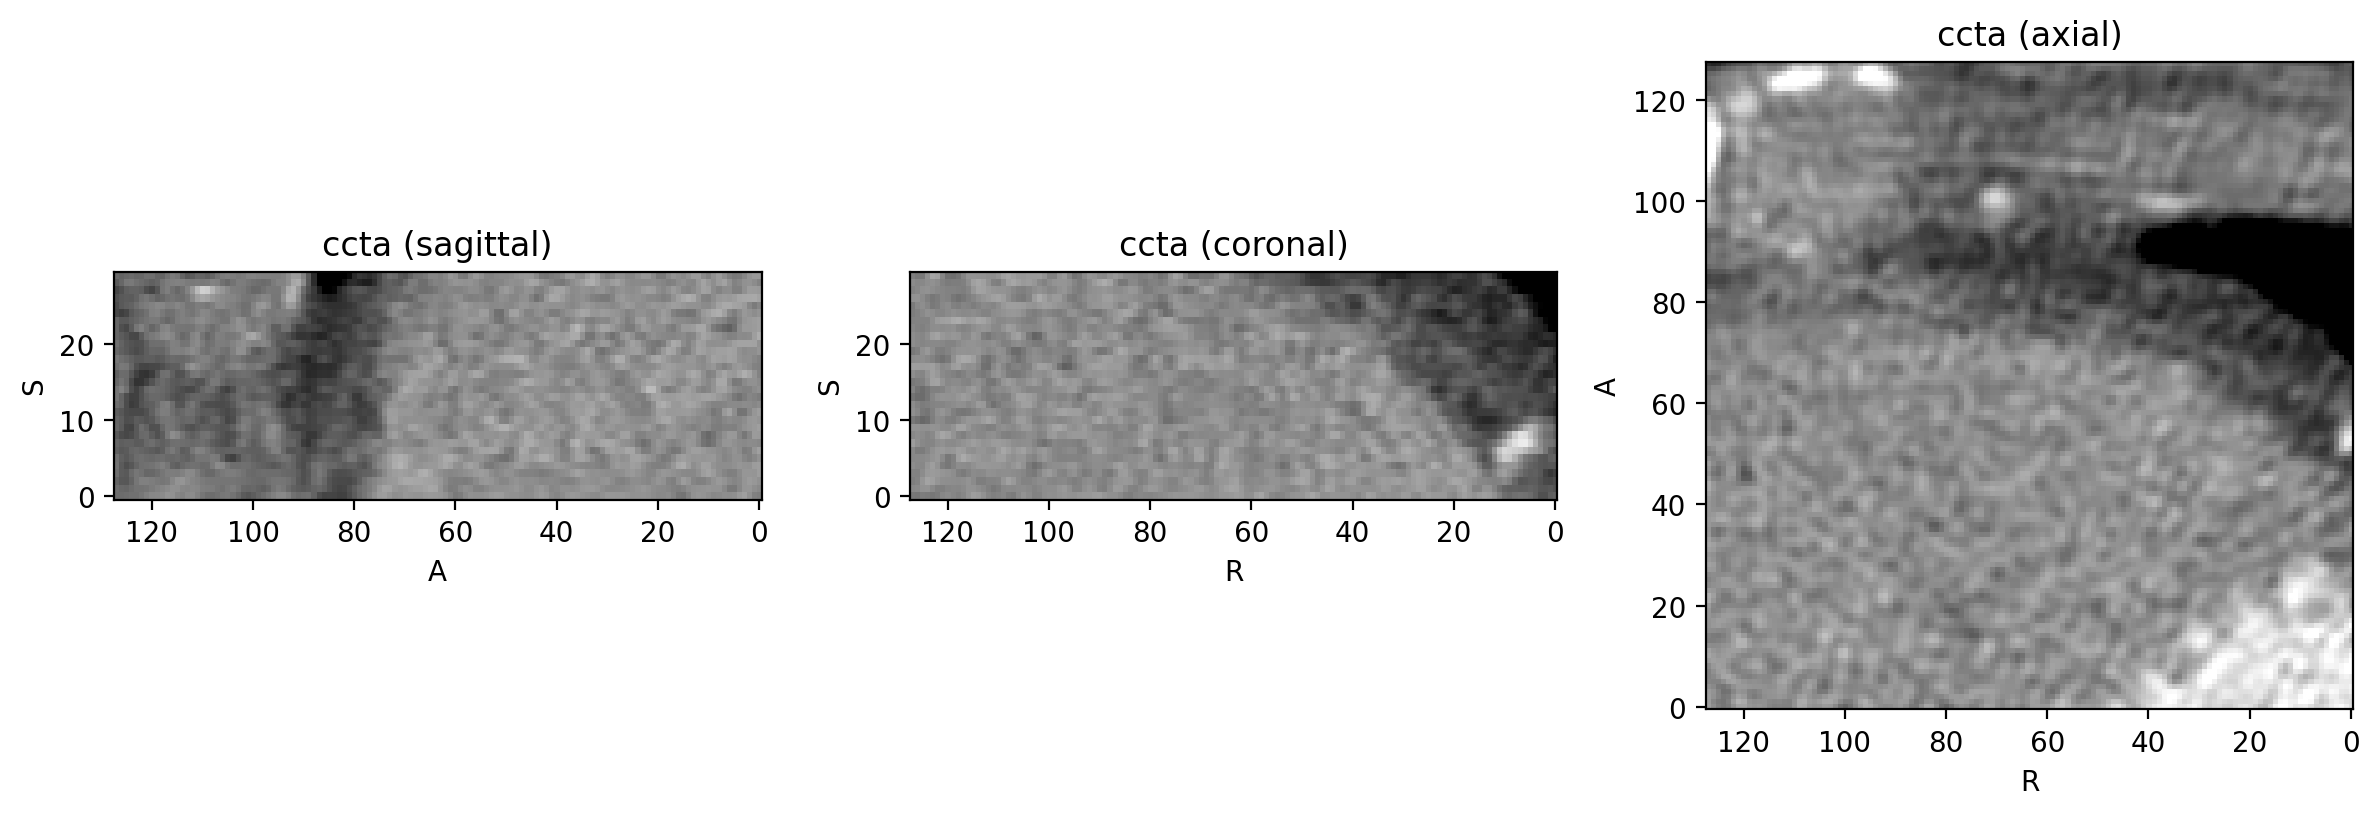

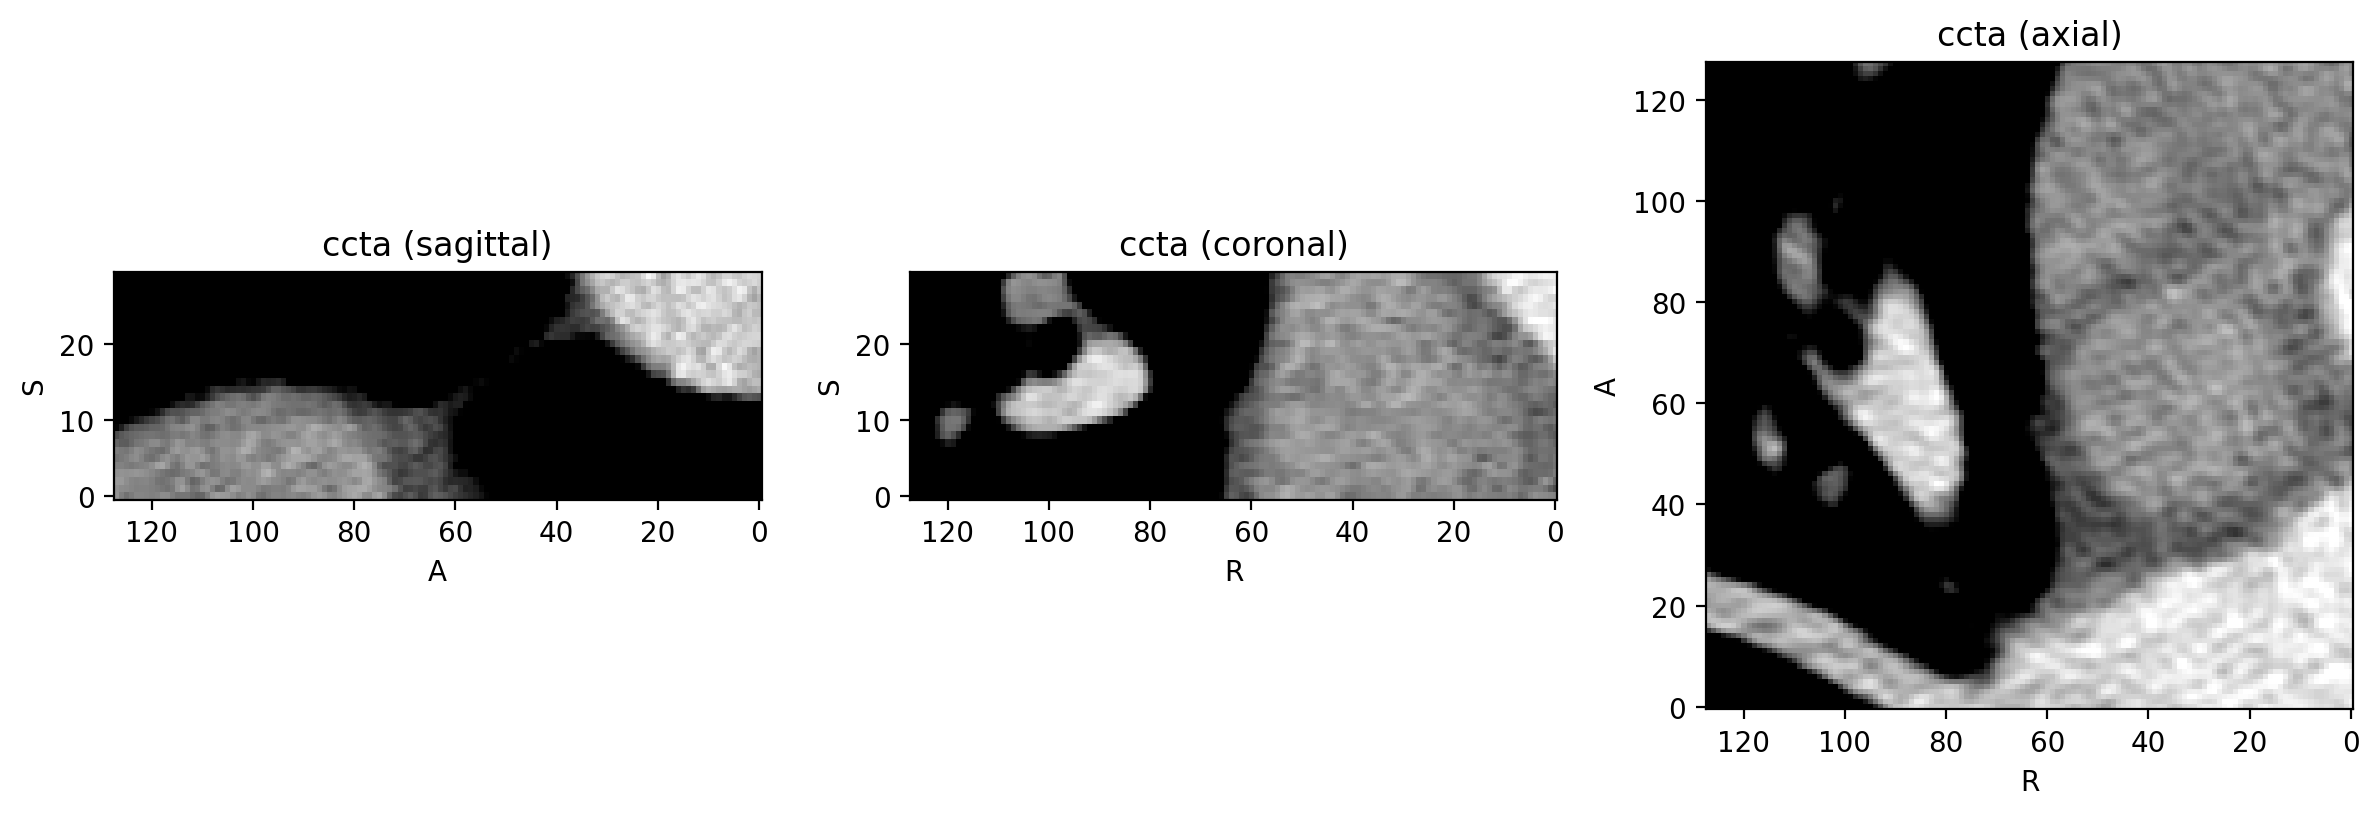

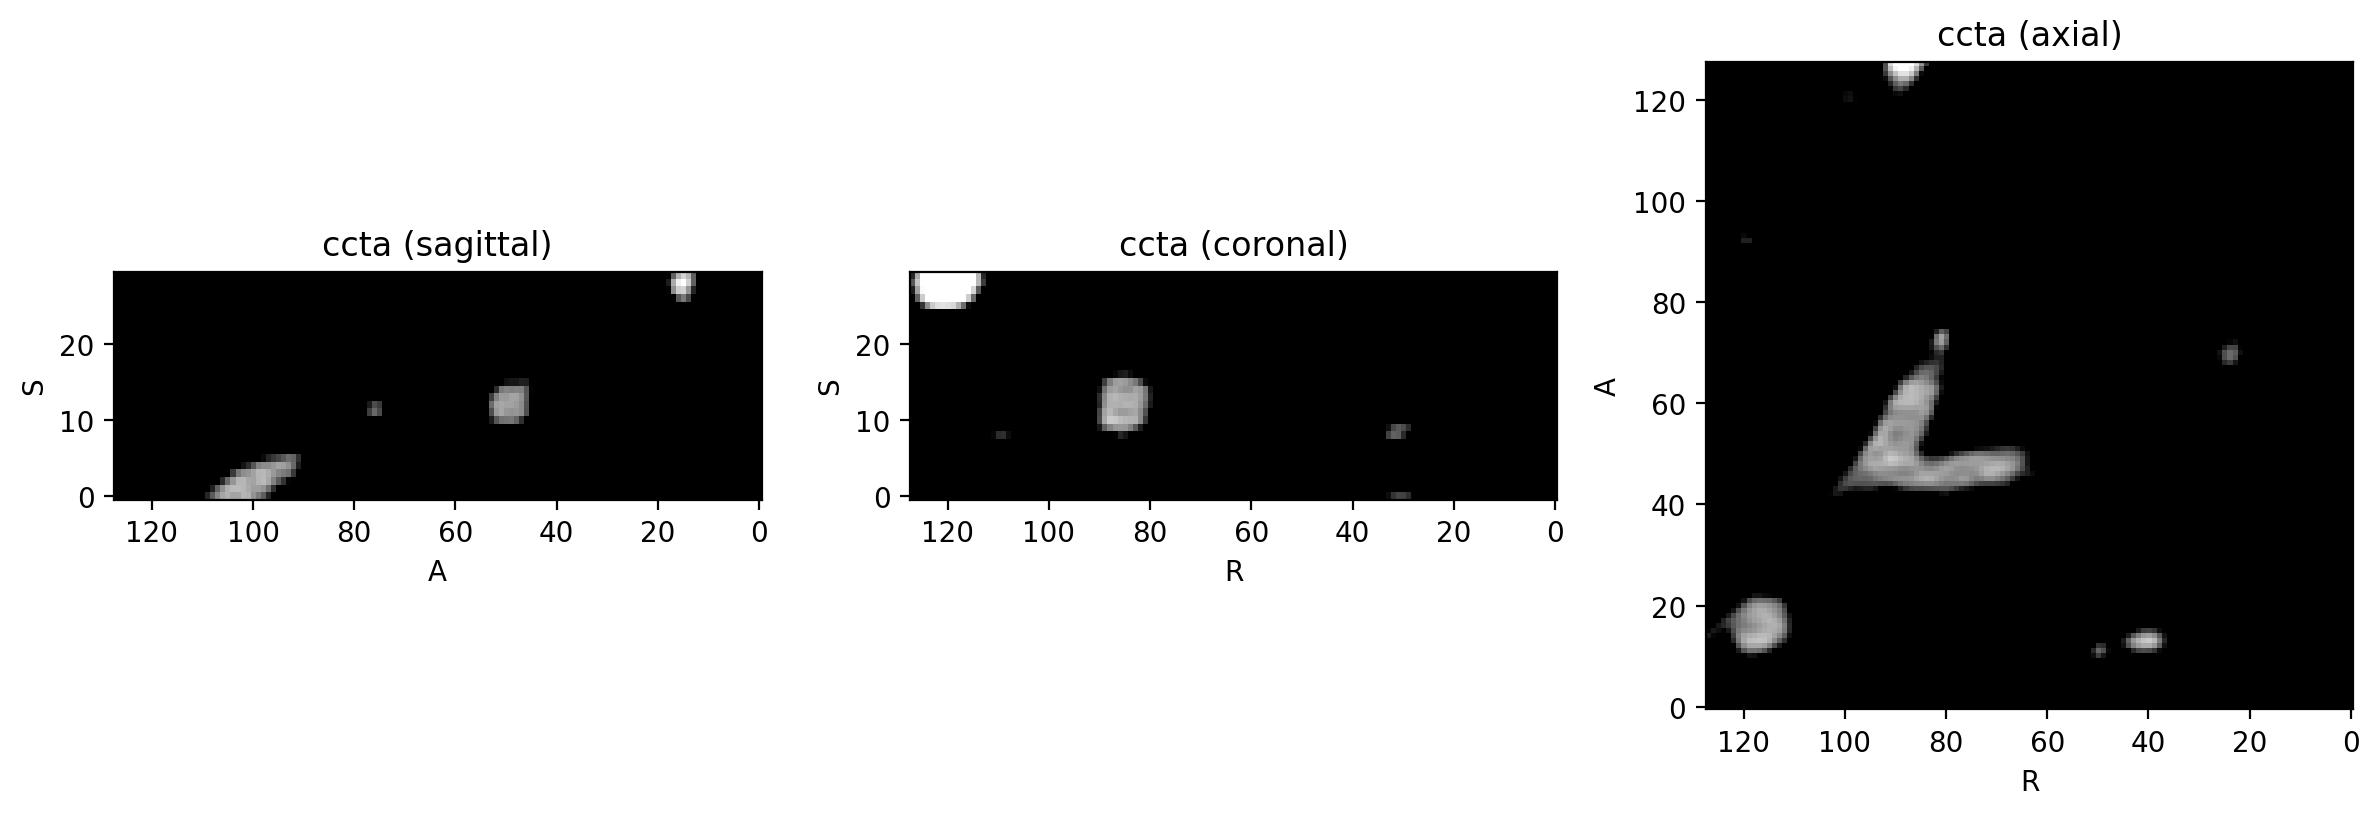

In [20]:
gen = sampler(dataset[0])
for _, patch in zip(range(5), gen):
    patch.plot()

In [320]:
img, meta, f = io_utils.load_h5_image(
    "/home/marco/data/ASOCA_Philips/images/ASOCA-010.h5"
)
img.shape

(512, 512, 212)

In [321]:
# NOTE xyz is the center of the patch
def extract_3D_patch(
    img: Union[np.ndarray, h5py.Dataset], sizes: np.ndarray, xyz: np.ndarray
) -> np.ndarray:
    half = sizes // 2
    bbox = np.dstack([xyz - half, xyz + half]).squeeze()
    return img[*[slice(*box) for box in bbox]]


def extract_random_3D_patch(
    img: Union[np.ndarray, h5py.Dataset],
    sizes: np.ndarray,
    rng: Optional[np.random.Generator] = None,
) -> Tuple[np.ndarray, np.ndarray]:
    if rng is None:
        rng = np.random.default_rng()
    xyz = [
        rng.integers(extent, dim_high - extent + 1)
        for dim_high, extent in zip(img.shape, sizes // 2)
    ]
    xyz = np.array(xyz)
    return extract_3D_patch(img, sizes, xyz), xyz

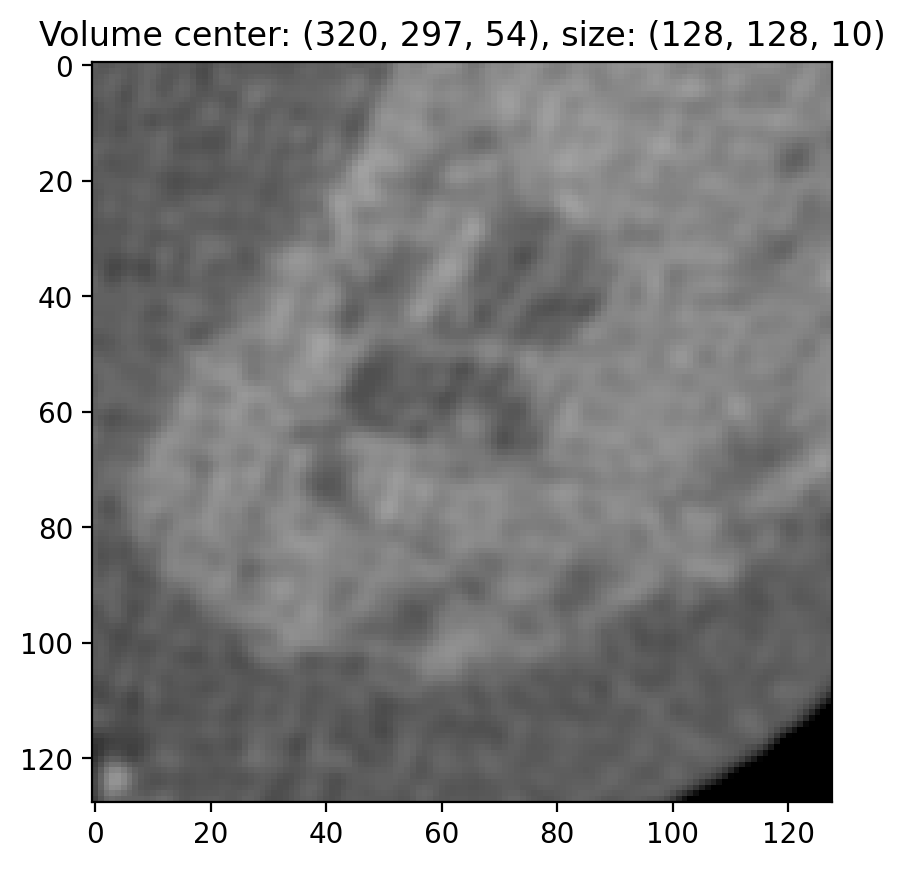

In [322]:
voxel_volume, patch_center = extract_random_3D_patch(img, PATCH_SIZE)

plt.imshow(
    voxel_volume[..., voxel_volume.shape[-1] // 2].T, cmap="gray", vmin=VMIN, vmax=VMAX
)
plt.title(f"Volume center: {tuple(patch_center)}, size: {tuple(PATCH_SIZE)}")
plt.show()
plt.close()

[[229 226 163]
 [278 298 181]]


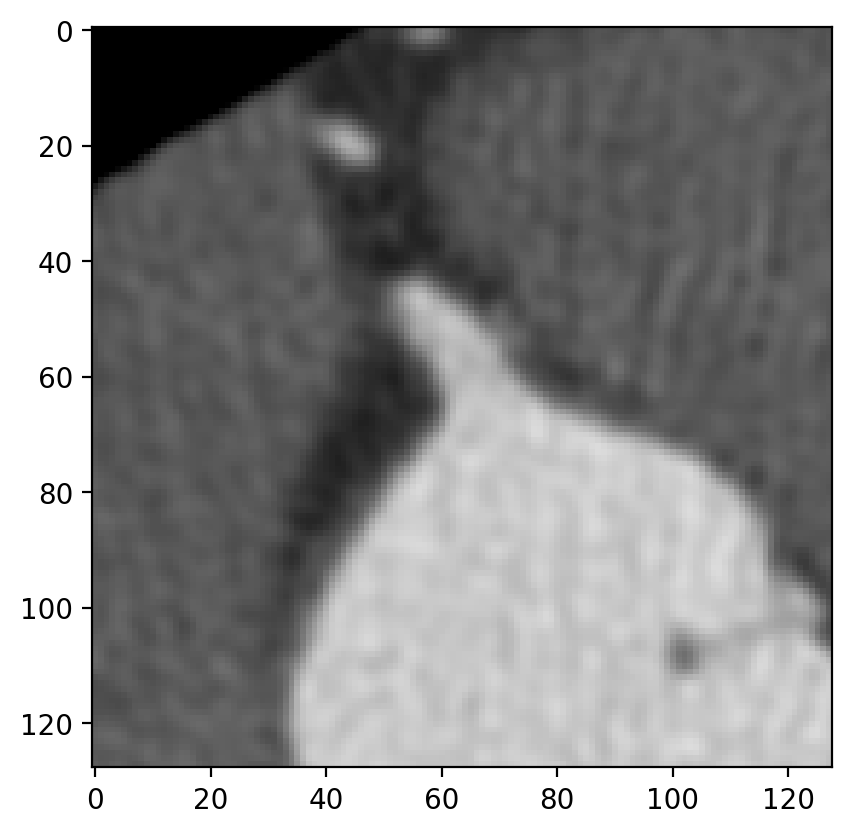

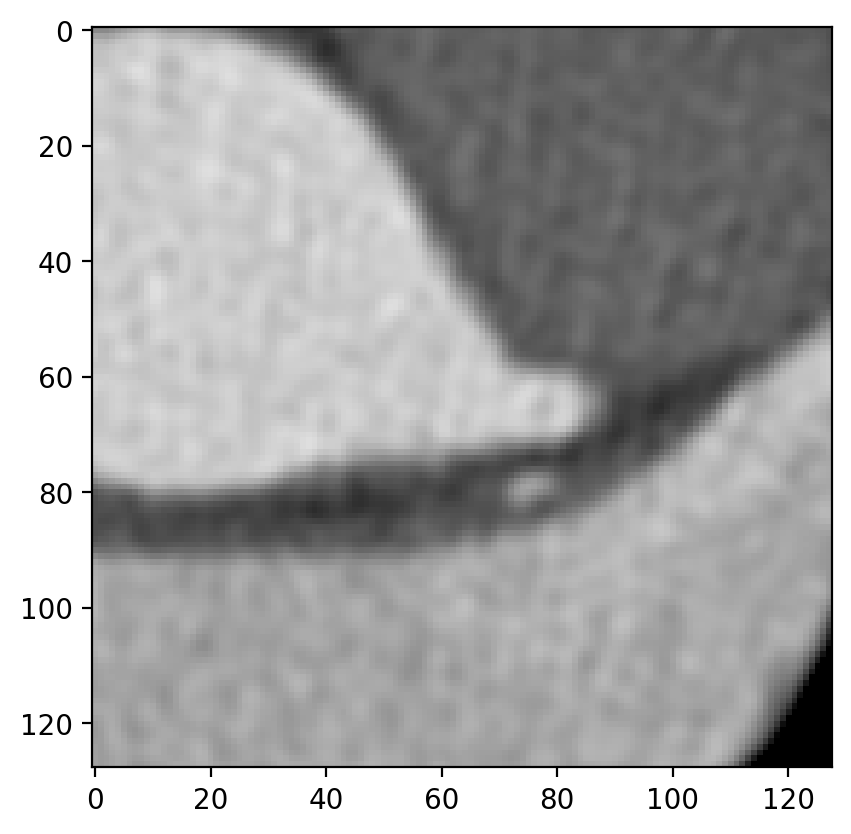

In [315]:
img_ostia = geom.world_to_image_coords(meta["ostia"], meta["offset"], meta["spacing"])
print(img_ostia)
voxel_volume = extract_3D_patch(img, PATCH_SIZE, img_ostia[0])

plt.imshow(
    voxel_volume[..., voxel_volume.shape[-1] // 2].T, cmap="gray", vmin=VMIN, vmax=VMAX
)
plt.show()
plt.close()

voxel_volume = extract_3D_patch(img, PATCH_SIZE, img_ostia[1])

plt.imshow(
    voxel_volume[..., voxel_volume.shape[-1] // 2].T, cmap="gray", vmin=VMIN, vmax=VMAX
)
plt.show()
plt.close()